# Identifying Cost Drivers and Improving Financial Sustainability for Hospitals

**Problem statement**

Hospitals operate in a challenging financial landscape, balancing service quality with cost constraints. By analyzing key financial and operational metrics, this project aims to uncover:

- The primary drivers of high costs and low efficiency.
- Differences in financial performance between hospital types (e.g., rural vs. urban).
- Strategies to improve profitability and support financially vulnerable hospitals.


Expected Outcomes:
- Key Cost Drivers Identified: A clear understanding of factors contributing to high costs and inefficiencies.
- Hospital Segmentation: Classification of hospitals into financial health categories to tailor recommendations.
- Actionable Recommendations: Data-driven suggestions for improving cost efficiency, enhancing revenue streams, and supporting financially vulnerable hospitals.


## Imports and utility functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.stats import f_oneway, levene, shapiro, ttest_ind, mstats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
def impute_in_beds_range(row, col_name):
    if pd.isnull(row[col_name]):
        n_beds = row['Number of Beds']
        if pd.isnull(n_beds):
            # If 'Number of Beds' is missing, impute with overall median
            median_value = df[col_name].median()
            return median_value
        else:
            # Define the bed range
            min_beds = n_beds - 50
            max_beds = n_beds + 50
            # Filter the dataframe to get hospitals within this bed range and with non-missing salary values
            df_filtered = df[(df['Number of Beds'] >= min_beds) & (df['Number of Beds'] <= max_beds) & (~df[col_name].isnull())]
            # If no hospitals are found in this range, expand the range
            range_expansion = 50 
            while df_filtered.empty:
                min_beds -= range_expansion
                max_beds += range_expansion
                # Ensure min_beds is not less than zero and max_beds doesn't exceed the maximum number of beds
                min_beds = max(min_beds, df['Number of Beds'].min())
                max_beds = min(max_beds, df['Number of Beds'].max())
                # Break the loop if the range cannot be expanded further
                if min_beds == df['Number of Beds'].min() and max_beds == df['Number of Beds'].max():
                    break
                df_filtered = df[(df['Number of Beds'] >= min_beds) & (df['Number of Beds'] <= max_beds) & (~df[col_name].isnull())]
            if df_filtered.empty:
                # If still no hospitals are found, use overall median
                median_value = df[col_name].median()
            else:
                # Compute the median salary variable in this filtered set
                median_value = df_filtered[col_name].median()
            return median_value
    else:
        # If the salary variable is not missing, return the original value
        return row[col_name]

In [3]:
# Load the dataset
file_path = 'Hospital_Provider_Cost_Report_2022.csv'
df = pd.read_csv(file_path)
# Data dictionary: https://data.cms.gov/sites/default/files/2024-03/9756088d-5280-4090-80b9-449d31ef25a3/Cost%20Report%20Data%20Dictionary%20Update.pdf
df.head()

rpt_rec_num  Provider CCN                         Hospital Name  \
0       717629        344028  STRATEGIC BEHAVIORAL CENTER - GARNER   
1       717969        180078  PAUL B. HALL REGIONAL MEDICAL CENTER   
2       719460        520210  MARSHFIELD MEDICAL CENTER-EAU CLAIRE   
3       719475         63037         COBALT REHAB HOSP WESTMINSTER   
4       721379        340123           AMERICAN HEALTHCARE SYSTEMS   

                        Street Address         City State Code    Zip Code  \
0                 3200 WATERFIELD ROAD       GARNER         NC  27529-7727   
1  PAUL B. HALL REGIONAL MEDICAL CENTE  PAINTSVILLE         KY       41240   
2                      2116 CRAIG ROAD   EAU CLAIRE         WI       54701   
3                  6500 WEST 104TH AVE  WESTMINSTER         CO       80020   
4        373 NORTH FAYETTEVILLE STREET     ASHEBORO         NC      27204-   

     County  Medicare CBSA Number Rural Versus Urban  ...  \
0       NaN                   NaN                NaN  ...   
1   JOHNSON               99918.0                  R  ...   
2       NaN               20740.0                  U  ...   
3       NaN               79740.0                  U  ...   
4  RANDOLPH               24660.0                  U  ...   

  Net Income from Service to Patients  Total Other Income  Total Income  \
0                                 NaN                 NaN           NaN   
1                            634470.0           2151392.0     2785862.0   
2                          -4259661.0            845990.0    -3413671.0   
3                          -1980346.0                 NaN    -1980346.0   
4                          -5248749.0          -6661015.0   -11909764.0   

  Total Other Expenses  Net Income  Cost To Charge Ratio  \
0                  NaN         NaN                   NaN   
1                 15.0   2785847.0              0.074617   
2             151877.0  -3565548.0              0.451411   
3                  NaN  -1980346.0                   NaN   
4                  NaN -11909764.0              0.160752   

   Net Revenue from Medicaid  Medicaid Charges  \
0                        NaN               NaN   
1                  1114125.0        26708472.0   
2                 14333809.0        18797586.0   
3                        NaN               NaN   
4                  1724073.0         6249901.0   

   Net Revenue from Stand-Alone CHIP  Stand-Alone CHIP Charges  
0                                NaN                       NaN  
1                                NaN                       NaN  
2                                NaN                       NaN  
3                                NaN                       NaN  
4                                NaN                       NaN  

[5 rows x 117 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6064 entries, 0 to 6063
Columns: 117 entries, rpt_rec_num to Stand-Alone CHIP Charges
dtypes: float64(103), int64(4), object(10)
memory usage: 5.4+ MB


In [5]:
df.describe()

rpt_rec_num   Provider CCN  Medicare CBSA Number  Provider Type  \
count    6064.000000    6064.000000           5981.000000    6064.000000   
mean   754291.104387  269404.638522          53018.188263       1.708773   
std     10770.303579  160322.536510          34012.617263       1.431237   
min    717629.000000   10001.000000          10180.000000       1.000000   
25%    745140.750000  140157.250000          26420.000000       1.000000   
50%    755650.500000  260021.000000          39300.000000       1.000000   
75%    762052.750000  393035.250000          99916.000000       1.000000   
max    776832.000000  713029.000000          99966.000000      10.000000   

       Type of Control  FTE - Employees on Payroll  \
count      6064.000000                 5946.000000   
mean          4.178595                 1174.646171   
std           3.200321                13569.179424   
min           1.000000                    0.050000   
25%           2.000000                  129.112500   
50%           2.000000                  288.250000   
75%           5.000000                  902.735000   
max          13.000000               987647.000000   

       Number of Interns and Residents (FTE)  Total Days Title V  \
count                            1499.000000          134.000000   
mean                               94.247245         2175.932836   
std                               170.730012         4148.544626   
min                                 0.010000            1.000000   
25%                                 8.395000          110.000000   
50%                                28.330000          722.000000   
75%                                91.025000         2627.250000   
max                              1734.240000        32548.000000   

       Total Days Title XVIII  Total Days Title XIX  ...  \
count             5913.000000           5051.000000  ...   
mean              7604.045831           3390.437735  ...   
std              12124.613554           8052.593393  ...   
min                  1.000000              1.000000  ...   
25%                989.000000            121.000000  ...   
50%               2819.000000            680.000000  ...   
75%               9297.000000           3083.000000  ...   
max             176816.000000         175703.000000  ...   

       Net Income from Service to Patients  Total Other Income  Total Income  \
count                         5.979000e+03        5.751000e+03  5.973000e+03   
mean                         -1.213235e+07        2.212219e+07  9.155438e+06   
std                           1.469759e+08        9.444758e+07  1.285488e+08   
min                          -1.625376e+09       -2.963724e+08 -1.224029e+09   
25%                          -1.248723e+07        6.433410e+05 -3.266985e+06   
50%                          -2.037805e+06        2.970702e+06  1.004401e+06   
75%                           2.852722e+06        1.060829e+07  8.285527e+06   
max                           7.864650e+09        1.794124e+09  7.903916e+09   

       Total Other Expenses    Net Income  Cost To Charge Ratio  \
count          1.778000e+03  5.974000e+03           4600.000000   
mean           6.840885e+06  7.117901e+06              1.349845   
std            4.677254e+07  1.289053e+08             53.870625   
min           -5.686516e+08 -1.224029e+09              0.041931   
25%            1.000000e+00 -3.868518e+06              0.197872   
50%            9.739300e+04  7.509730e+05              0.289937   
75%            1.888425e+06  7.395911e+06              0.475700   
max            7.197225e+08  7.919570e+09           3636.891704   

       Net Revenue from Medicaid  Medicaid Charges  \
count               4.385000e+03      4.373000e+03   
mean                3.172794e+07      1.942532e+08   
std                 8.750084e+07      4.248297e+08   
min                -1.449717e+07      1.000000e+01   
25%                 2.851322e+06      1.118957e+07   
50%                 9.163034e+06  

## Data Wrangling

### Handle missing values

In [6]:
missing_values = df.isnull().sum()

In [7]:
missing_percentage = (missing_values / len(df)) * 100
missing_percentage.sort_values(ascending=False)

Outlier Payments For Discharges                        100.000000
DRG Amounts Other Than Outlier Payments                100.000000
Hospital Total Days Title V For Adults & Peds           97.955145
Total Discharges Title V                                97.922164
Hospital Total Discharges Title V For Adults & Peds     97.922164
                                                          ...    
Provider Type                                            0.000000
Type of Control                                          0.000000
Fiscal Year Begin Date                                   0.000000
Provider CCN                                             0.000000
rpt_rec_num                                              0.000000
Length: 117, dtype: float64

In [8]:
# Drop variables with high missingness or irrelavant
drop_vars = [
    'Outlier Payments For Discharges',
    'DRG Amounts Other Than Outlier Payments',
    'Hospital Total Days Title V For Adults & Peds',
    'Hospital Total Discharges Title V For Adults & Peds',
    'Total Discharges Title V',
    'Total Days Title V',
    'Wage-Related Costs (RHC/FQHC)',
    'Total Other Expenses',
    'County',
    'Street Address']

df.drop(columns=drop_vars, inplace=True)

In [9]:
# List of variables to fill with zero - Missingness likely indicates the absence of a feature or activity
fill_zero_vars = [
    # Financial variables
    'Notes Receivable',
    'Unsecured Loans',
    'Mortgage Payable',
    'Notes Payable',
    'Investments',
    'Temporary Investments',
    'Deferred Income',
    'Payroll Taxes Payable',
    'Notes and Loans Payable (Short Term)',
    'Other Current Assets',
    'Other Long Term Liabilities',
    'Other Assets',
    'Total Other Assets',
    'Less: Allowances for Uncollectible Notes and Accounts Receivable',
    'Other Current Liabilities',
    'Total Long Term Liabilities',
    # Operational variables
    'Number of Interns and Residents (FTE)',
    'Wage Related Costs for Interns and Residents',
    'Wage Related Costs for Part - A Teaching Physicians',
    'Contract Labor: Direct Patient Care',
    # Program-specific variables
    'Net Revenue from Stand-Alone CHIP',
    'Stand-Alone CHIP Charges',
    'Managed Care Simulated Payments',
    'Total IME Payment',
    'DRG Amounts Before October 1',
    'DRG Amounts After October 1',
    'Disproportionate Share Adjustment',
    'Allowable DSH Percentage',
    # Asset variables
    'Health Information Technology Designated Assets',
    'Leasehold Improvements',
    'Minor Equipment Depreciable',
    'Fixed Equipment',
    'Land Improvements',
    'Land',
    'Buildings',
    'Major Movable Equipment',
    # Charity care and bad debt
    'Cost of Charity Care',
    'Total Bad Debt Expense',
    'Cost of Uncompensated Care',
    'Total Unreimbursed and Uncompensated Care',
    # Medicaid variables
    'Medicaid Charges',
    'Net Revenue from Medicaid',
    # Title variables
    'Hospital Total Discharges Title XIX For Adults & Peds',
    'Total Discharges Title XIX',
    'Hospital Total Days Title XIX For Adults & Peds',
    'Total Days Title XIX',
    'Hospital Total Days Title XVIII For Adults & Peds',
    'Total Days Title XVIII',
    'Hospital Total Discharges Title XVIII For Adults & Peds',
    'Total Discharges Title XVIII',
    # Outpatient variables
    'Outpatient Revenue',
    'Outpatient Total Charges',
    'Inpatient Revenue',
    'Inpatient Total Charges',
    # Other financial variables
    'Prepaid Expenses',
    'Inventory',
    'Salaries, Wages, and Fees Payable'
]

In [10]:
for col in fill_zero_vars:
    df[col] = df[col].fillna(0)        

In [11]:
# Impute Values Based on Number of Beds Range - value has correlation with beds
vars_corr_beds = [
    'Wage-Related Costs (Core)', 
    'Total Salaries (adjusted)', 
    'Inpatient Revenue', 
    'Total Patient Revenue', 
    'Net Patient Revenue', 
    'Total Fixed Assets',
    'Total Current Liabilities',
    'Total Liabilities',
    'Total Current Assets',
    'Total Other Income',
    'General Fund Balance',
    'Total Fund Balances',
    'Total Liabilities and Fund Balances',
    'Total Assets',
    'Depreciation Cost',
    "Less Contractual Allowance and Discounts on Patients' Accounts",
]
for col in vars_corr_beds:
    df[col] = df.apply(lambda row: impute_in_beds_range(row, col), axis=1)    

In [12]:
# Compute 'Cost To Charge Ratio' Where Missing

missing_ratio = df['Cost To Charge Ratio'].isnull()

# Ensure 'Total Costs' and 'Combined Outpatient + Inpatient Total Charges' are not zero to avoid division by zero
valid_indices = (df['Total Costs'] != 0) & (df['Combined Outpatient + Inpatient Total Charges'] != 0)
indices_to_compute = missing_ratio & valid_indices
df.loc[indices_to_compute, 'Cost To Charge Ratio'] = (
    df.loc[indices_to_compute, 'Total Costs'] /
    df.loc[indices_to_compute, 'Combined Outpatient + Inpatient Total Charges']
)

In [13]:
df['Cost To Charge Ratio'].isnull().sum()

83

In [14]:
# Remove if no 'Total Costs' and 'Combined Outpatient + Inpatient Total Charges'
df = df[~df['Cost To Charge Ratio'].isnull()]
df['Cost To Charge Ratio'].isnull().sum()

0

In [15]:
# Re-check missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print(missing_percentage[missing_percentage > 0].sort_values(ascending=False).to_string())

Cash on Hand and in Banks                                                  7.824778
Accounts Payable                                                           5.366995
Accounts Receivable                                                        4.898846
FTE - Employees on Payroll                                                 0.585186
Hospital Total Days (V + XVIII + XIX + Unknown) For Adults & Peds          0.351112
Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults & Peds    0.317673
Total Discharges (V + XVIII + XIX + Unknown)                               0.317673
Total Days (V + XVIII + XIX + Unknown)                                     0.300953
Hospital Number of Beds For Adults & Peds                                  0.250794
Hospital Total Bed Days Available For Adults & Peds                        0.234075
Total Bed Days Available                                                   0.183916
Number of Beds                                                             0

In [16]:
financial_vars = ['Cash on Hand and in Banks', 'Accounts Payable', 'Accounts Receivable']

for col in financial_vars:
    if col in df.columns:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)

In [17]:
# Re-check missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print(missing_percentage[missing_percentage > 0].sort_values(ascending=False).to_string())

FTE - Employees on Payroll                                                 0.585186
Hospital Total Days (V + XVIII + XIX + Unknown) For Adults & Peds          0.351112
Total Discharges (V + XVIII + XIX + Unknown)                               0.317673
Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults & Peds    0.317673
Total Days (V + XVIII + XIX + Unknown)                                     0.300953
Hospital Number of Beds For Adults & Peds                                  0.250794
Hospital Total Bed Days Available For Adults & Peds                        0.234075
Number of Beds                                                             0.183916
Total Bed Days Available                                                   0.183916
Total Income                                                               0.133757
Net Income                                                                 0.117037
Number of Beds + Total for all Subproviders                                0

In [18]:
df.isnull().any(axis=1).sum()

65

In [19]:
df = df.dropna()
df.isnull().sum().any()

False

### Check Data Type

In [20]:
print(df.dtypes.to_string())

rpt_rec_num                                                                  int64
Provider CCN                                                                 int64
Hospital Name                                                               object
City                                                                        object
State Code                                                                  object
Zip Code                                                                    object
Medicare CBSA Number                                                       float64
Rural Versus Urban                                                          object
CCN Facility Type                                                           object
Provider Type                                                                int64
Type of Control                                                              int64
Fiscal Year Begin Date                                                      object
Fisc

In [21]:
df['rpt_rec_num'] = df['rpt_rec_num'].astype(str)
df['Provider CCN'] = df['Provider CCN'].astype(str)
df['Medicare CBSA Number'] = df['Medicare CBSA Number'].astype(str)
df['Provider Type'] = df['Provider Type'].astype('category')
df['Type of Control'] = df['Type of Control'].astype('category')
df['Fiscal Year Begin Date'] = pd.to_datetime(df['Fiscal Year Begin Date'])
df['Fiscal Year End Date'] = pd.to_datetime(df['Fiscal Year End Date'])

### Check abnormal vals

In [22]:
df = df[df['Less Total Operating Expense'] > 0]

In [23]:
df[['Inpatient Revenue','Outpatient Revenue']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5913 entries, 1 to 6063
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Inpatient Revenue   5913 non-null   float64
 1   Outpatient Revenue  5913 non-null   float64
dtypes: float64(2)
memory usage: 138.6 KB


### Add features

In [24]:
df['total_cost_per_bed'] = df['Total Costs'] / df['Number of Beds']
df['net_income_per_bed'] = df['Net Income'] / df['Number of Beds']
df['bed_days_available_per_bed'] = df['Total Bed Days Available'] / df['Number of Beds']
df['discharge_per_bed'] = df['Total Discharges (V + XVIII + XIX + Unknown)'] / df['Number of Beds']

df['labor_cost_perc'] = df['Total Salaries From Worksheet A'] / df['Total Costs']

df['net_patient_revenue_perc']=df['Net Patient Revenue']/df['Net Income']
df['total_patient_revenue_perc']=df['Total Patient Revenue']/df['Total Income']
df['net_medicaid_revenue_perc'] = df['Net Revenue from Medicaid'] / df['Net Patient Revenue']
df['charity_care_cost_per'] = df['Cost of Charity Care']/df['Total Costs']
df['uncompensated_care_cost_perc'] = df['Cost of Uncompensated Care']/df['Total Costs']
df['unreimbursed_uncompensated_care_cost_perc'] = df['Total Unreimbursed and Uncompensated Care']/df['Total Costs'] 
df['inventory_cost_perc'] = df['Inventory']/df['Total Costs']
df['land_and_buildings_cost_perc'] = (df['Land']+df['Buildings']+df['Land Improvements'])/df['Total Costs']

df['inpatient_to_outpatient_charges'] = df['Inpatient Total Charges'] / df['Outpatient Total Charges']
df['Outpatient Revenue'] = df['Outpatient Revenue'].replace(0, 1e-9)
df['inpatient_to_outpatient_reveneu'] = df['Inpatient Revenue'] / df['Outpatient Revenue']
df['intern_to_employees']=df['Number of Interns and Residents (FTE)'] / df['FTE - Employees on Payroll']

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/268686793.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['uncompensated_care_cost_perc'] = df['Cost of Uncompensated Care']/df['Total Costs']
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/268686793.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['unreimbursed_uncompensated_care_cost_perc'] = df['Total Unreimbursed and Uncompensated Care']/df['Total Costs']
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/268686793

In [25]:
relavent_features = [
    'Hospital Name',
    'Number of Beds',
    'Rural Versus Urban',
    'CCN Facility Type',
    'Provider Type', 
    'Type of Control',       
    'Accounts Receivable',
    'Cost To Charge Ratio',
    'net_income_per_bed',
    'total_cost_per_bed',
'bed_days_available_per_bed',
'discharge_per_bed',
'labor_cost_perc',
'net_patient_revenue_perc',
'total_patient_revenue_perc',
'net_medicaid_revenue_perc',
'charity_care_cost_per',
'uncompensated_care_cost_perc',
'unreimbursed_uncompensated_care_cost_perc',
'inventory_cost_perc',
'land_and_buildings_cost_perc',
'inpatient_to_outpatient_reveneu',
'intern_to_employees',
]

In [26]:
full_df = df
df = df[relavent_features]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5913 entries, 1 to 6063
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   Hospital Name                              5913 non-null   object  
 1   Number of Beds                             5913 non-null   float64 
 2   Rural Versus Urban                         5913 non-null   object  
 3   CCN Facility Type                          5913 non-null   object  
 4   Provider Type                              5913 non-null   category
 5   Type of Control                            5913 non-null   category
 6   Accounts Receivable                        5913 non-null   float64 
 7   Cost To Charge Ratio                       5913 non-null   float64 
 8   net_income_per_bed                         5913 non-null   float64 
 9   total_cost_per_bed                         5913 non-null   float64 
 10  bed_days_availabl

## EDA

In [27]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

### Correlation Analysis

In [28]:
corr_matrix = df[numerical_cols].corr()

def correlation_heatmap(target_var, threshold=0.5):   
    top_corr = corr_matrix[target_var].sort_values(ascending=False)
    filtered_vars = top_corr[abs(top_corr) > threshold].index

    plt.figure(figsize=(8, 6))
    sns.heatmap(df[filtered_vars].corr(), cmap='coolwarm', fmt='.2f')
    plt.title(f"Filtered Correlation Matrix (|r| > {threshold}) with{target_var}")
    plt.show()
    
    # Display the top correlations as a table
    print(f"Correlations with {target_var}:")
    top_corr_table = top_corr[abs(top_corr) > threshold].to_frame(name='Correlation').reset_index()
    top_corr_table.columns = ['Variable', 'Correlation']
    display(top_corr_table)

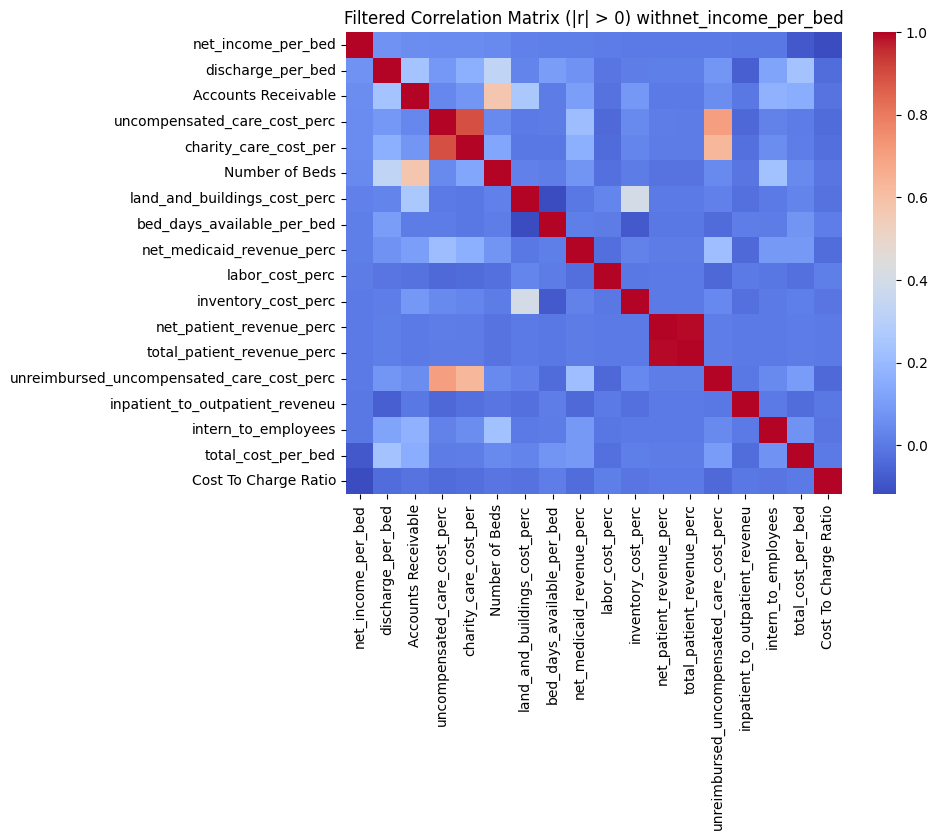

Correlations with net_income_per_bed:


Variable  Correlation
0                          net_income_per_bed     1.000000
1                           discharge_per_bed     0.065586
2                         Accounts Receivable     0.054815
3                uncompensated_care_cost_perc     0.049848
4                       charity_care_cost_per     0.049688
5                              Number of Beds     0.043188
6                land_and_buildings_cost_perc     0.018604
7                  bed_days_available_per_bed     0.014718
8                   net_medicaid_revenue_perc     0.014638
9                             labor_cost_perc     0.003969
10                        inventory_cost_perc     0.001589
11                   net_patient_revenue_perc     0.000185
12                 total_patient_revenue_perc     0.000164
13  unreimbursed_uncompensated_care_cost_perc    -0.000074
14            inpatient_to_outpatient_reveneu    -0.001960
15                        intern_to_employees    -0.004504
16                         total_cost_per_bed    -0.085001
17                       Cost To Charge Ratio    -0.116412

In [29]:
correlation_heatmap('net_income_per_bed', threshold=0)

#### Insights

Weak Correlations Across the Board:
- Most features have correlations close to zero with net_income_per_bed.
- The strongest correlation, discharge_per_bed (0.0656), is still very weak, indicating limited linear relationships.

Negative Correlations:
- Features like total_cost_per_bed (-0.0850) and Cost To Charge Ratio (-0.1164) show slight negative correlations with net_income_per_bed, which might hint at minor cost efficiency effects.


### Distribution & Outliers

In [30]:
df.describe().transpose()

count          mean           std  \
Number of Beds                             5913.0  1.341689e+02  1.811763e+02   
Accounts Receivable                        5913.0  7.973867e+07  2.171774e+08   
Cost To Charge Ratio                       5913.0  3.260832e+00  5.923829e+01   
net_income_per_bed                         5913.0  1.151834e+04  7.227755e+05   
total_cost_per_bed                         5913.0  1.283377e+06  1.559186e+06   
bed_days_available_per_bed                 5913.0  3.606025e+02  3.396757e+01   
discharge_per_bed                          5913.0  3.068752e+01  2.173664e+01   
labor_cost_perc                            5913.0  4.728249e-01  7.997679e-01   
net_patient_revenue_perc                   5913.0 -2.478719e+04  2.151561e+06   
total_patient_revenue_perc                 5913.0 -2.212742e+04  2.186788e+06   
net_medicaid_revenue_perc                  5913.0  8.843059e-02  1.327644e-01   
charity_care_cost_per                      5913.0  2.011596e-02  3.366652e-02   
uncompensated_care_cost_perc               5913.0  3.469746e-02  4.377990e-02   
unreimbursed_uncompensated_care_cost_perc  5913.0  6.440156e-02  7.366140e-02   
inventory_cost_perc                        5913.0  2.111607e-02  1.024805e-01   
land_and_buildings_cost_perc               5913.0  6.637035e-01  1.386658e+00   
inpatient_to_outpatient_reveneu            5913.0  7.081220e+15  5.877517e+16   
intern_to_employees                        5913.0  9.258196e-03  4.178870e-02   

                                                    min           25%  \
Number of Beds                             1.000000e+00  2.500000e+01   
Accounts Receivable                       -1.313464e+09  5.261482e+06   
Cost To Charge Ratio                       4.193100e-02  2.081050e-01   
net_income_per_bed                        -1.801121e+07 -6.428539e+04   
total_cost_per_bed                         1.450218e+04  5.353799e+05   
bed_days_available_per_bed                 4.280000e+00  3.650000e+02   
discharge_per_bed                          4.000000e-03  1.338983e+01   
labor_cost_perc                            2.758207e-07  3.693414e-01   
net_patient_revenue_perc                  -1.649584e+08 -9.103710e+00   
total_patient_revenue_perc                -1.659278e+08 -2.635212e+01   
net_medicaid_revenue_perc                 -2.430859e-01  0.000000e+00   
charity_care_cost_per                      0.000000e+00  0.000000e+00   
uncompensated_care_cost_perc              -2.127899e-03  7.399751e-04   
unreimbursed_uncompensated_care_cost_perc -2.127899e-03  3.429828e-03   
inventory_cost_perc                       -5.035279e+00  6.112551e-03   
land_and_buildings_cost_perc              -4.660144e-01  1.900713e-01   
inpatient_to_outpatient_reveneu            0.000000e+00  2.514765e-01   
intern_to_employees                        0.000000e+00  0.000000e+00   

                                                    50%           75%  \
Number of Beds                             6.400000e+01  1.710000e+02   
Accounts Receivable                        1.681691e+07  6.360564e+07   
Cost To Charge Ratio                       3.172200e-01  5.223095e-01   
net_income_per_bed                         1.721210e+04  1.201784e+05   
total_cost_per_bed                         1.073473e+06  1.658218e+06   
bed_days_available_per_bed                 3.650000e+02  3.650000e+02   
discharge_per_bed                          2.908333e+01  4.566667e+01   
labor_cost_perc                            4.416302e-01  5.225298e-01   
net_patient_revenue_perc                   4.067278e+00  1.232299e+01   
total_patient_revenue_perc                 1.074546e+01  3.929564e+01   
net_medicaid_revenue_perc                  6.686677e-02  1.243332e-01   
charity_care_cost_per                      7.990877e-03  2.500332e-02   
uncompensated_care_cost_perc               2.265980e-02  4.625613e-02   
unreimbursed_uncompensated_care_cost_perc  5.045696e-02  9.542840e-02   
inventory_cost_perc  

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.1

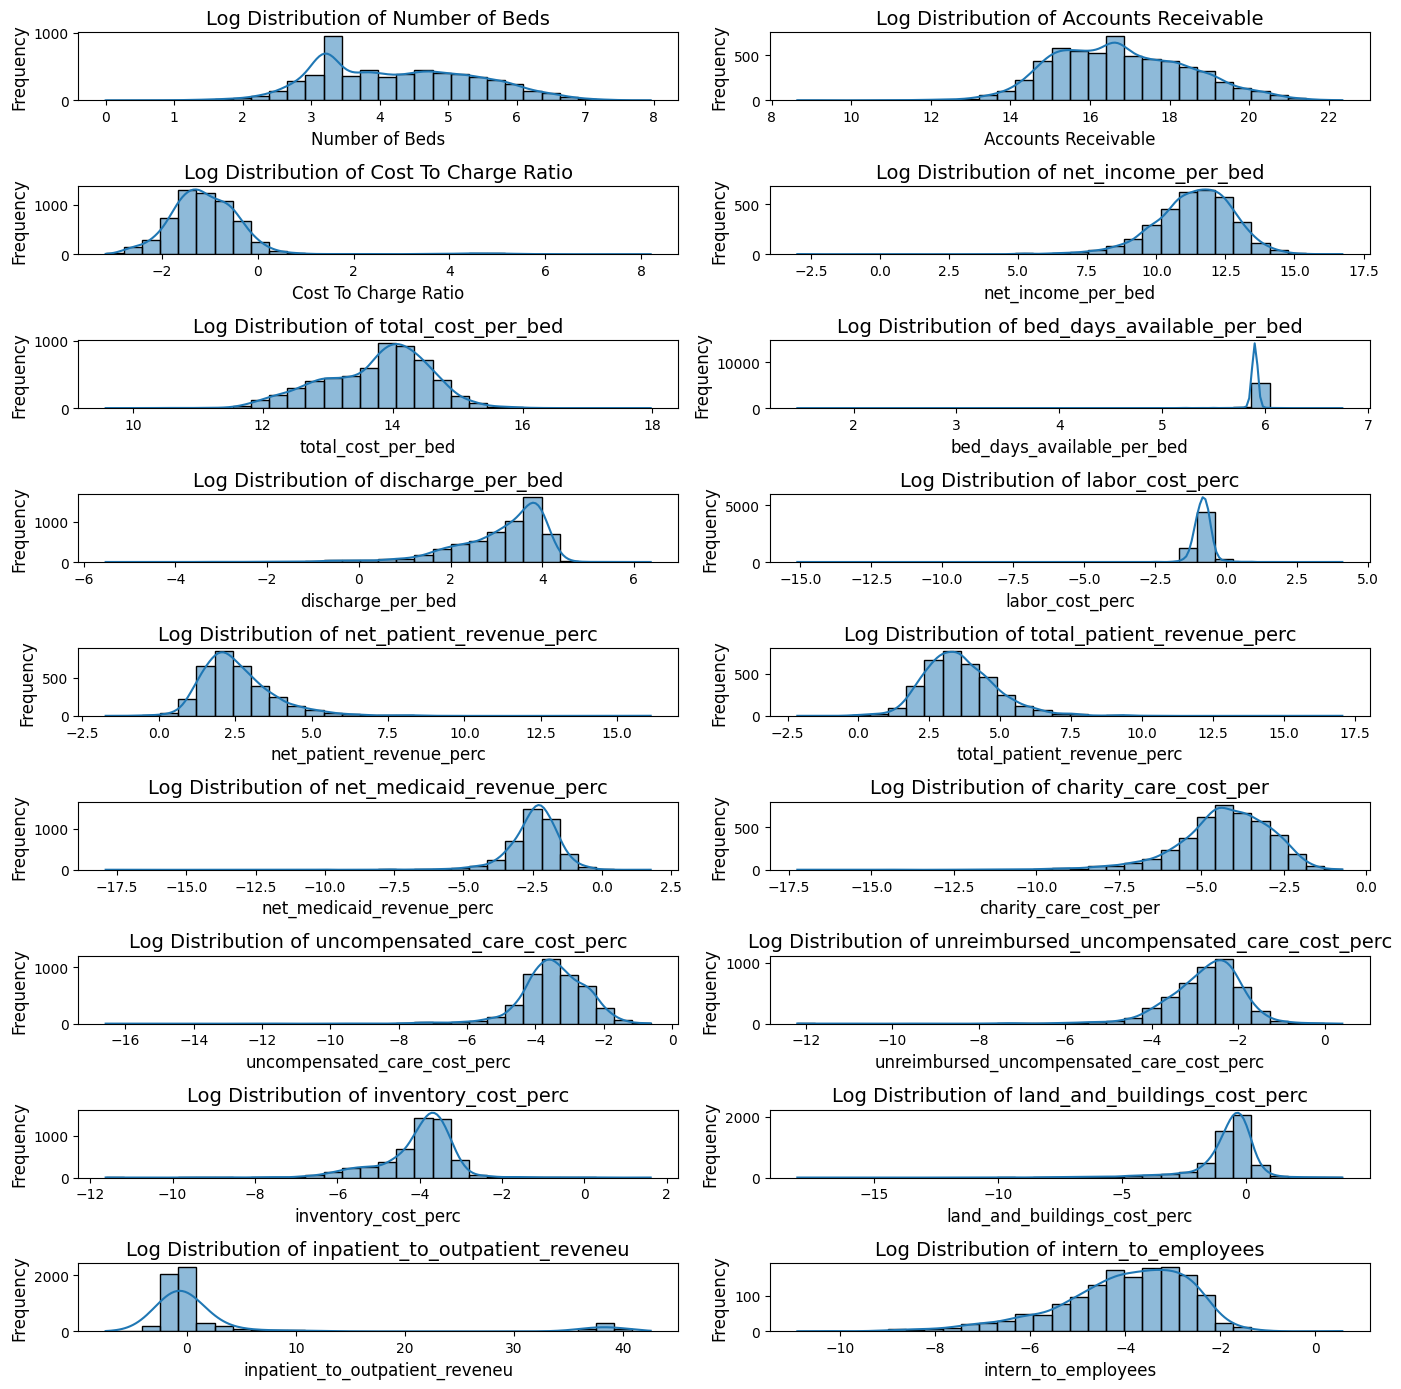

In [31]:
fig, axes = plt.subplots(9,2, figsize=(14,14))

for idx, column in enumerate(numerical_cols):
    row_idx = idx // 2
    col_idx = idx % 2
    sns.histplot(np.log(df[column]), kde=True, bins=30, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f"Log Distribution of {column}", fontsize=14)
    axes[row_idx, col_idx].set_xlabel(column, fontsize=12)
    axes[row_idx, col_idx].set_ylabel("Frequency", fontsize=12)

plt.tight_layout()  
plt.show()

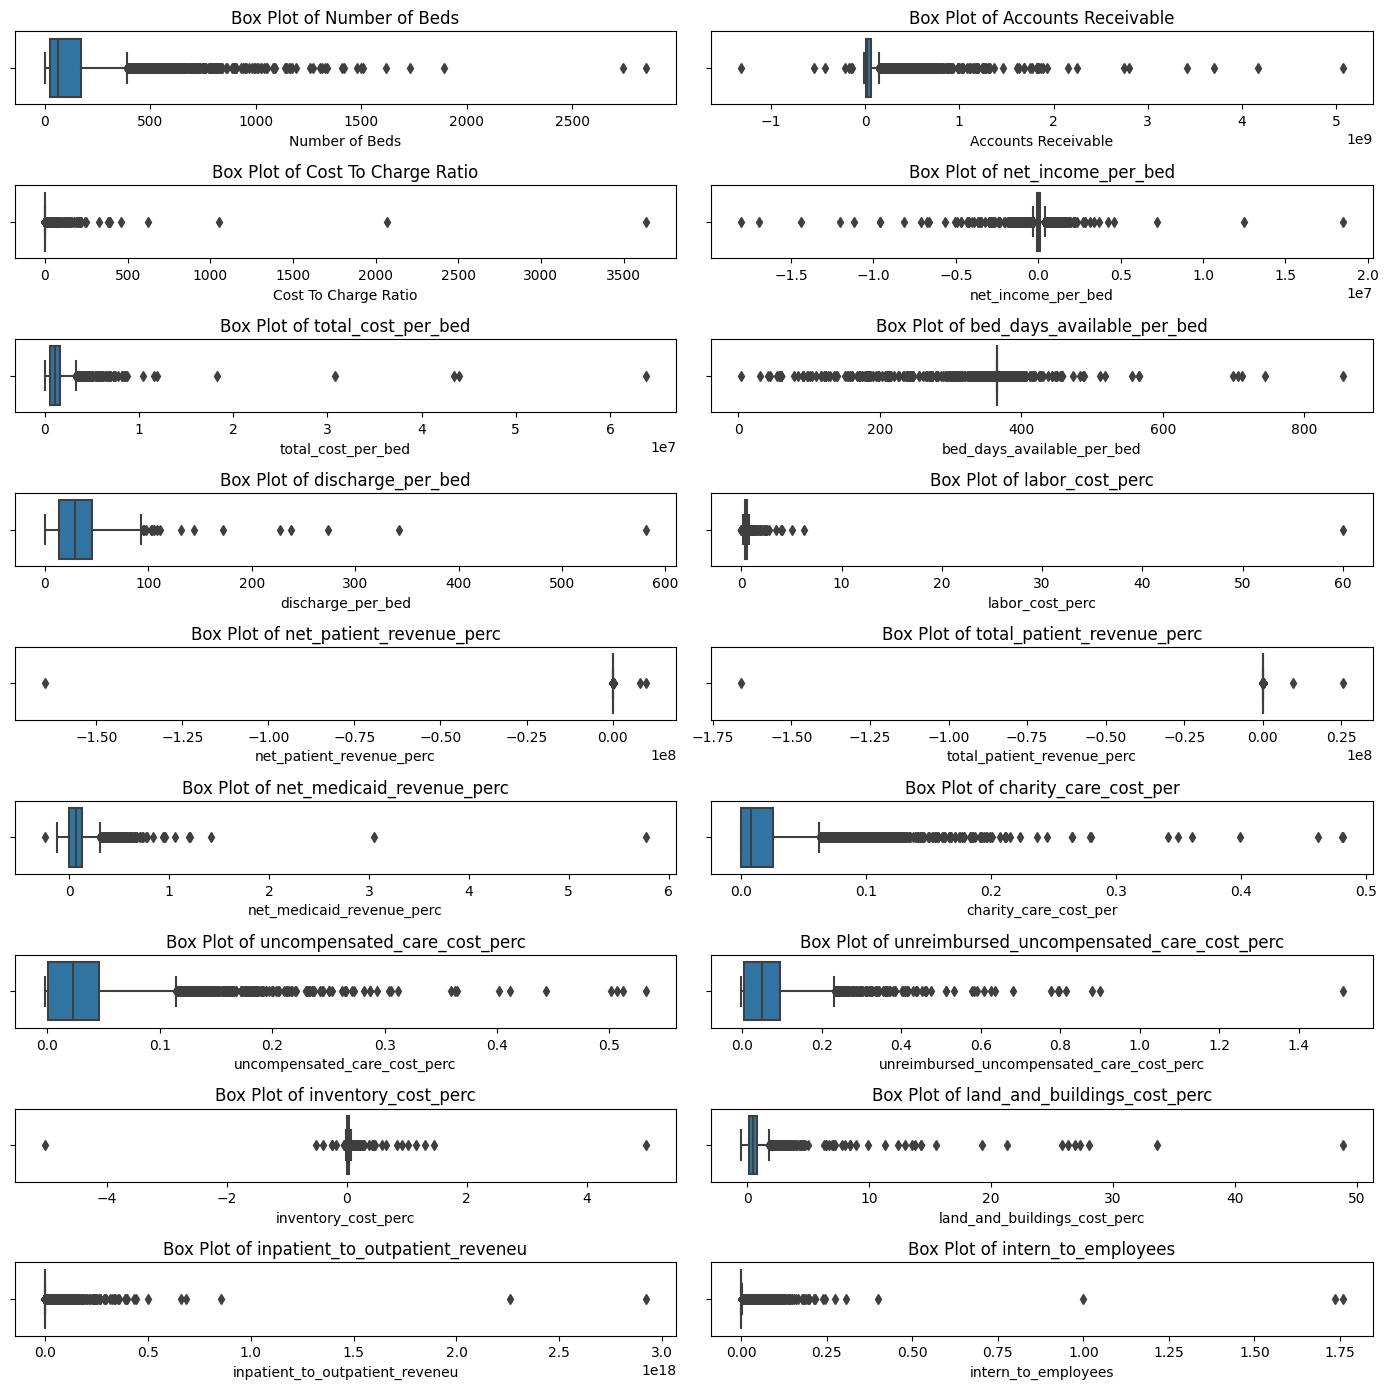

In [32]:
fig, axes = plt.subplots(9,2, figsize=(14,14))

for idx, column in enumerate(numerical_cols):
    row_idx = idx // 2
    col_idx = idx % 2
    sns.boxplot(x=df[column], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Box Plot of {column}')

plt.tight_layout()  
plt.show()

In [33]:
# Track the number of capped values for each column
winsorization_summary = []

# Apply Winsorization
for col in numerical_cols:
    before_capping = df[col].copy()
    df[col] = mstats.winsorize(df[col], limits=[0.01, 0.01])  # Cap the bottom 1% and top 1%
    capped_values = (before_capping != df[col]).sum()
    winsorization_summary.append({'Column': col, 'Capped Records': capped_values})

summary_df = pd.DataFrame(winsorization_summary)
print("Winsorization Summary:")
print(summary_df)

Winsorization Summary:
                                       Column  Capped Records
0                              Number of Beds             112
1                         Accounts Receivable             118
2                        Cost To Charge Ratio             118
3                          net_income_per_bed             118
4                          total_cost_per_bed             118
5                  bed_days_available_per_bed             116
6                           discharge_per_bed             117
7                             labor_cost_perc             118
8                    net_patient_revenue_perc             118
9                  total_patient_revenue_perc             118
10                  net_medicaid_revenue_perc              76
11                      charity_care_cost_per              59
12               uncompensated_care_cost_perc              78
13  unreimbursed_uncompensated_care_cost_perc              78
14                        inventory_cost_perc  

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/4060070894.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = mstats.winsorize(df[col], limits=[0.01, 0.01])  # Cap the bottom 1% and top 1%


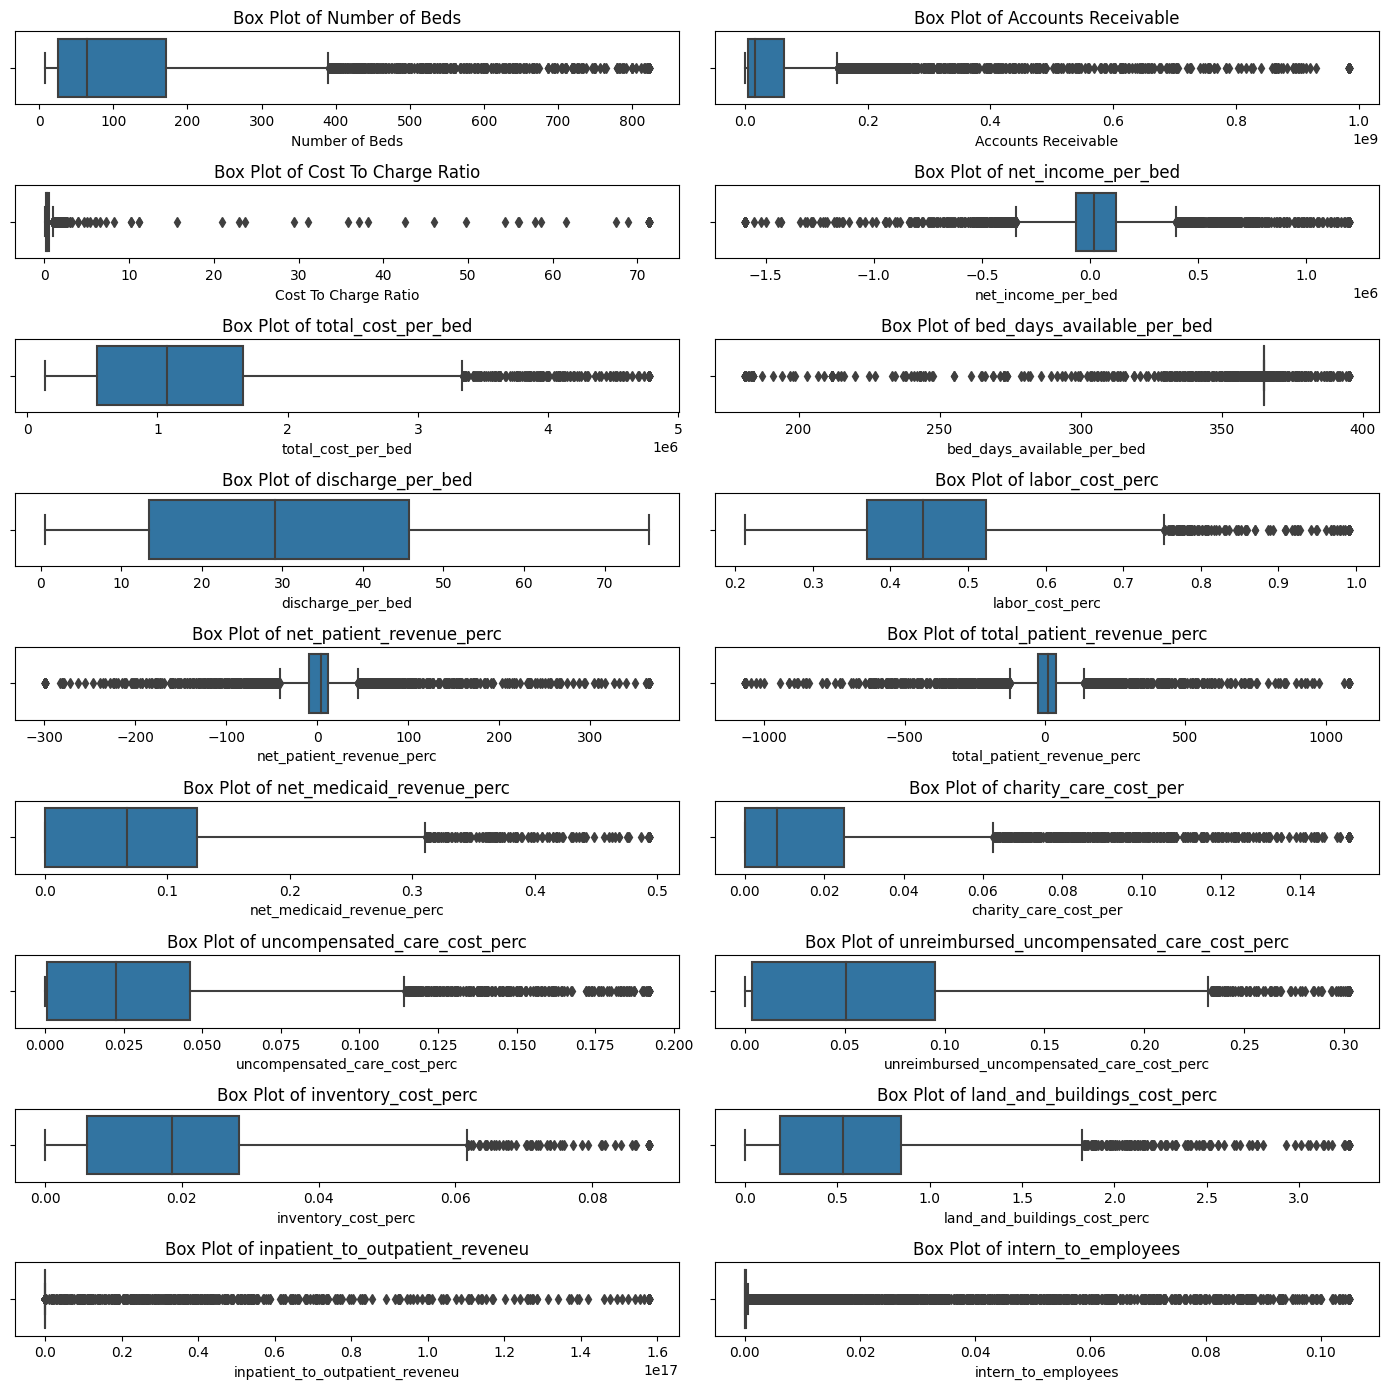

In [34]:
fig, axes = plt.subplots(9,2, figsize=(14,14))

for idx, column in enumerate(numerical_cols):
    row_idx = idx // 2
    col_idx = idx % 2
    sns.boxplot(x=df[column], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Box Plot of {column}')

plt.tight_layout()  
plt.show()

### Categorical Comparisons

In [35]:
categorical_cols = df.select_dtypes(exclude=['float64', 'int64']).columns.drop('Hospital Name')
#['Rural Versus Urban', 'CCN Facility Type', 'Provider Type', 'Type of Control']
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(f"Categories: {df[col].unique()[:10]}") 
    print("\n")

Rural Versus Urban: 2 unique values
Categories: ['R' 'U']


CCN Facility Type: 8 unique values
Categories: ['STH' 'RH' 'CAH' 'PH' 'LTCH' 'CH' 'ORD' 'RNMHC']


Provider Type: 9 unique values
Categories: [1, 5, 4, 2, 7, 3, 9, 6, 10]
Categories (9, int64): [1, 2, 3, 4, ..., 6, 7, 9, 10]


Type of Control: 13 unique values
Categories: [4, 2, 9, 1, 7, 6, 5, 10, 11, 13]
Categories (13, int64): [1, 2, 3, 4, ..., 10, 11, 12, 13]




/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


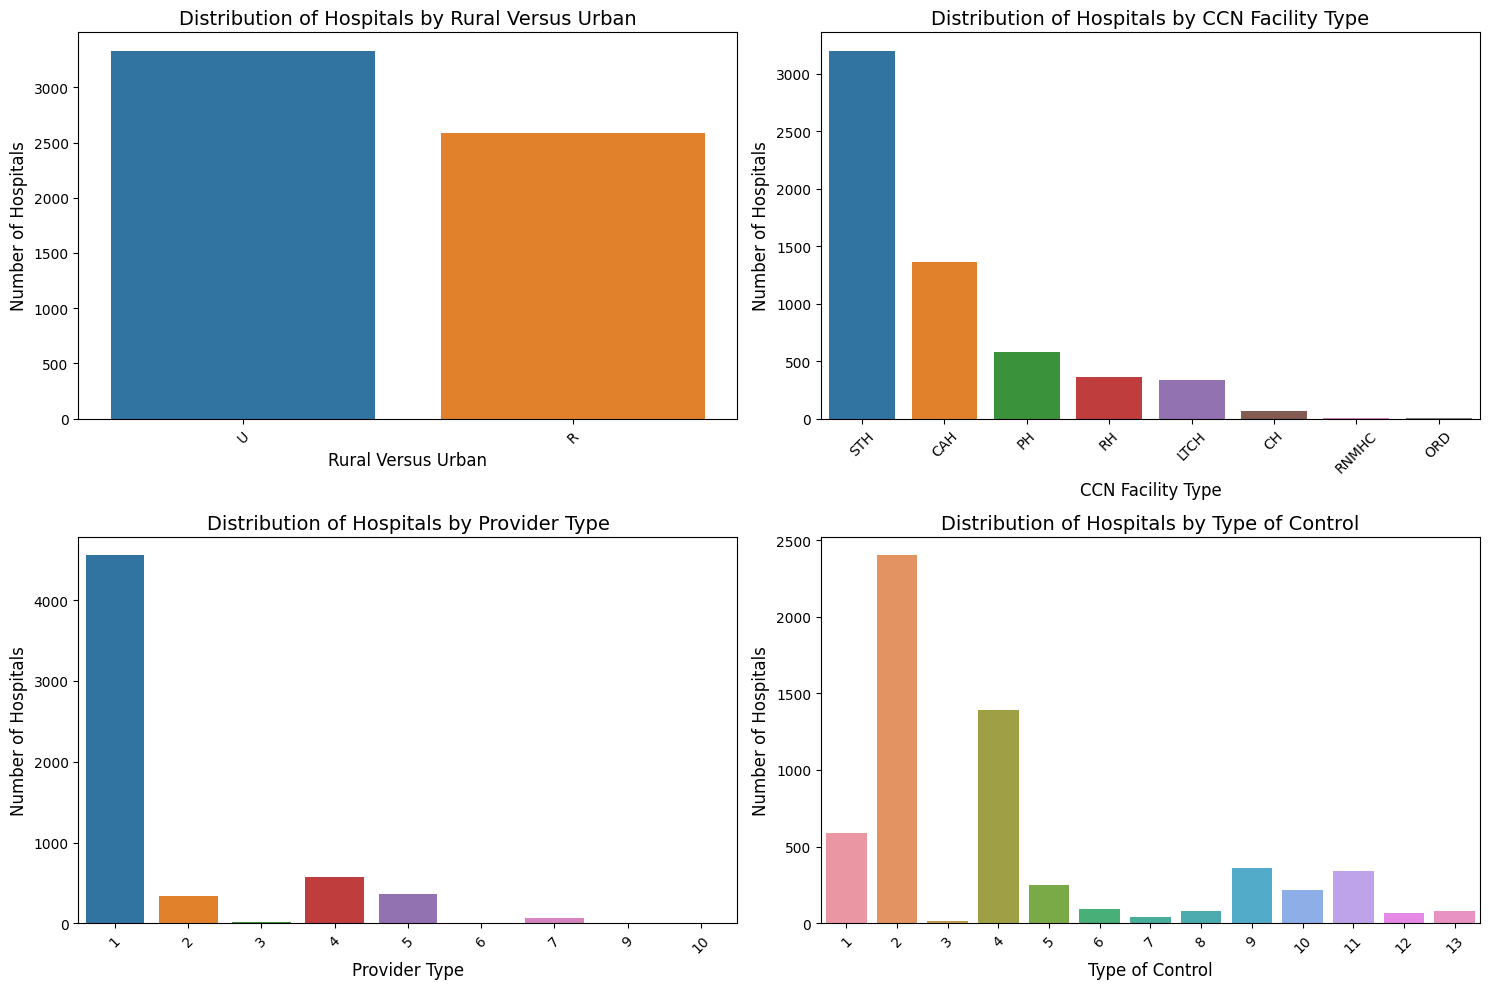

In [36]:
num_cols = 2
num_rows = -(-len(categorical_cols) // num_cols)  # Ceiling division
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Loop through each categorical column and plot
for i, col in enumerate(categorical_cols):
    row, col_index = divmod(i, num_cols)
    provider_type_counts = df[col].value_counts()
    sns.barplot(x=provider_type_counts.index, y=provider_type_counts.values, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'Distribution of Hospitals by {col}', fontsize=14)
    axes[row, col_index].set_xlabel(col, fontsize=12)
    axes[row, col_index].set_ylabel('Number of Hospitals', fontsize=12)
    axes[row, col_index].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

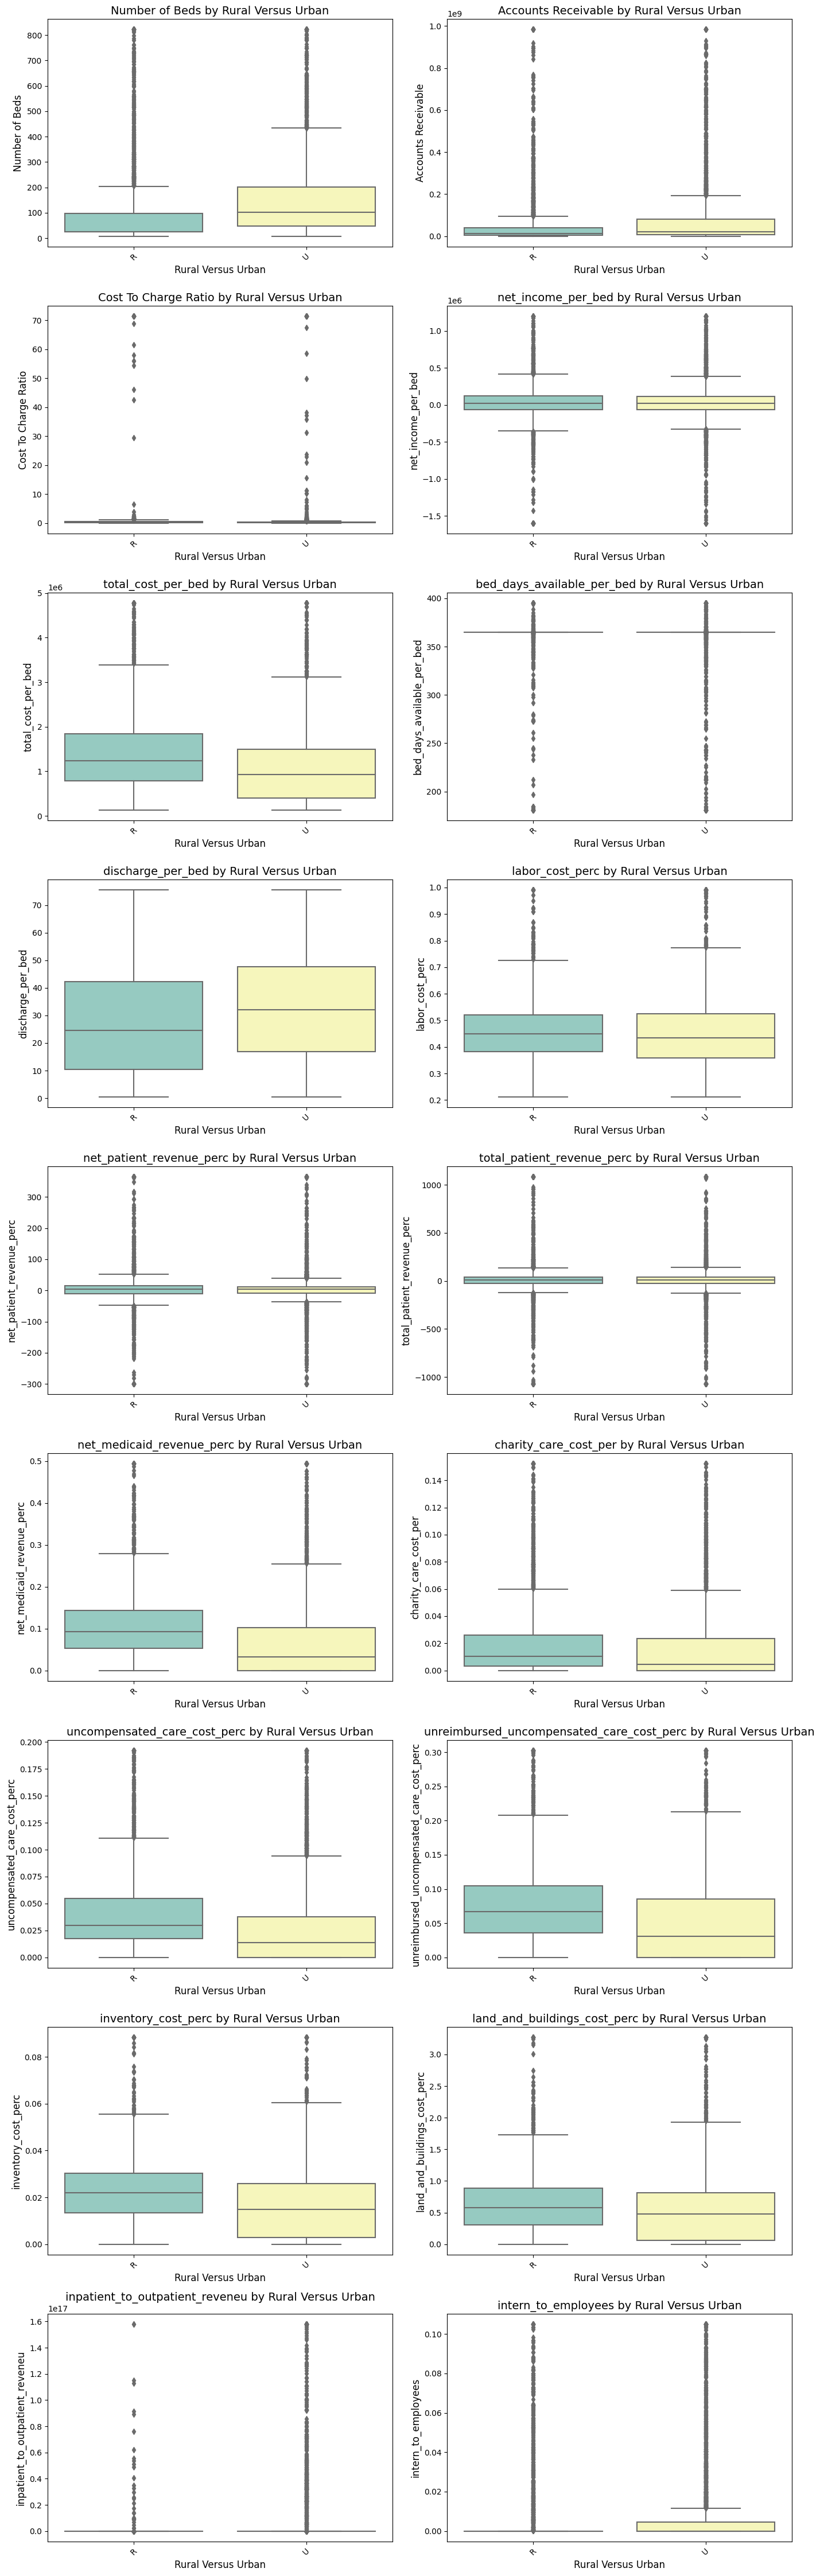


Summary statistics for Number of Beds by Rural Versus Urban:
                          mean  median         std  count
Rural Versus Urban                                       
R                   100.915182    25.0  161.316382   2582
U                   153.973582   102.0  154.559346   3331
T-test results for Number of Beds by Rural Versus Urban: t-statistic=-12.7749, p-value=0.0000

Summary statistics for Accounts Receivable by Rural Versus Urban:
                            mean      median           std  count
Rural Versus Urban                                               
R                   6.178292e+07  13716969.5  1.474650e+08   2582
U                   8.303706e+07  20373396.0  1.613326e+08   3331
T-test results for Accounts Receivable by Rural Versus Urban: t-statistic=-5.2748, p-value=0.0000

Summary statistics for Cost To Charge Ratio by Rural Versus Urban:
                        mean    median       std  count
Rural Versus Urban                                     
R  

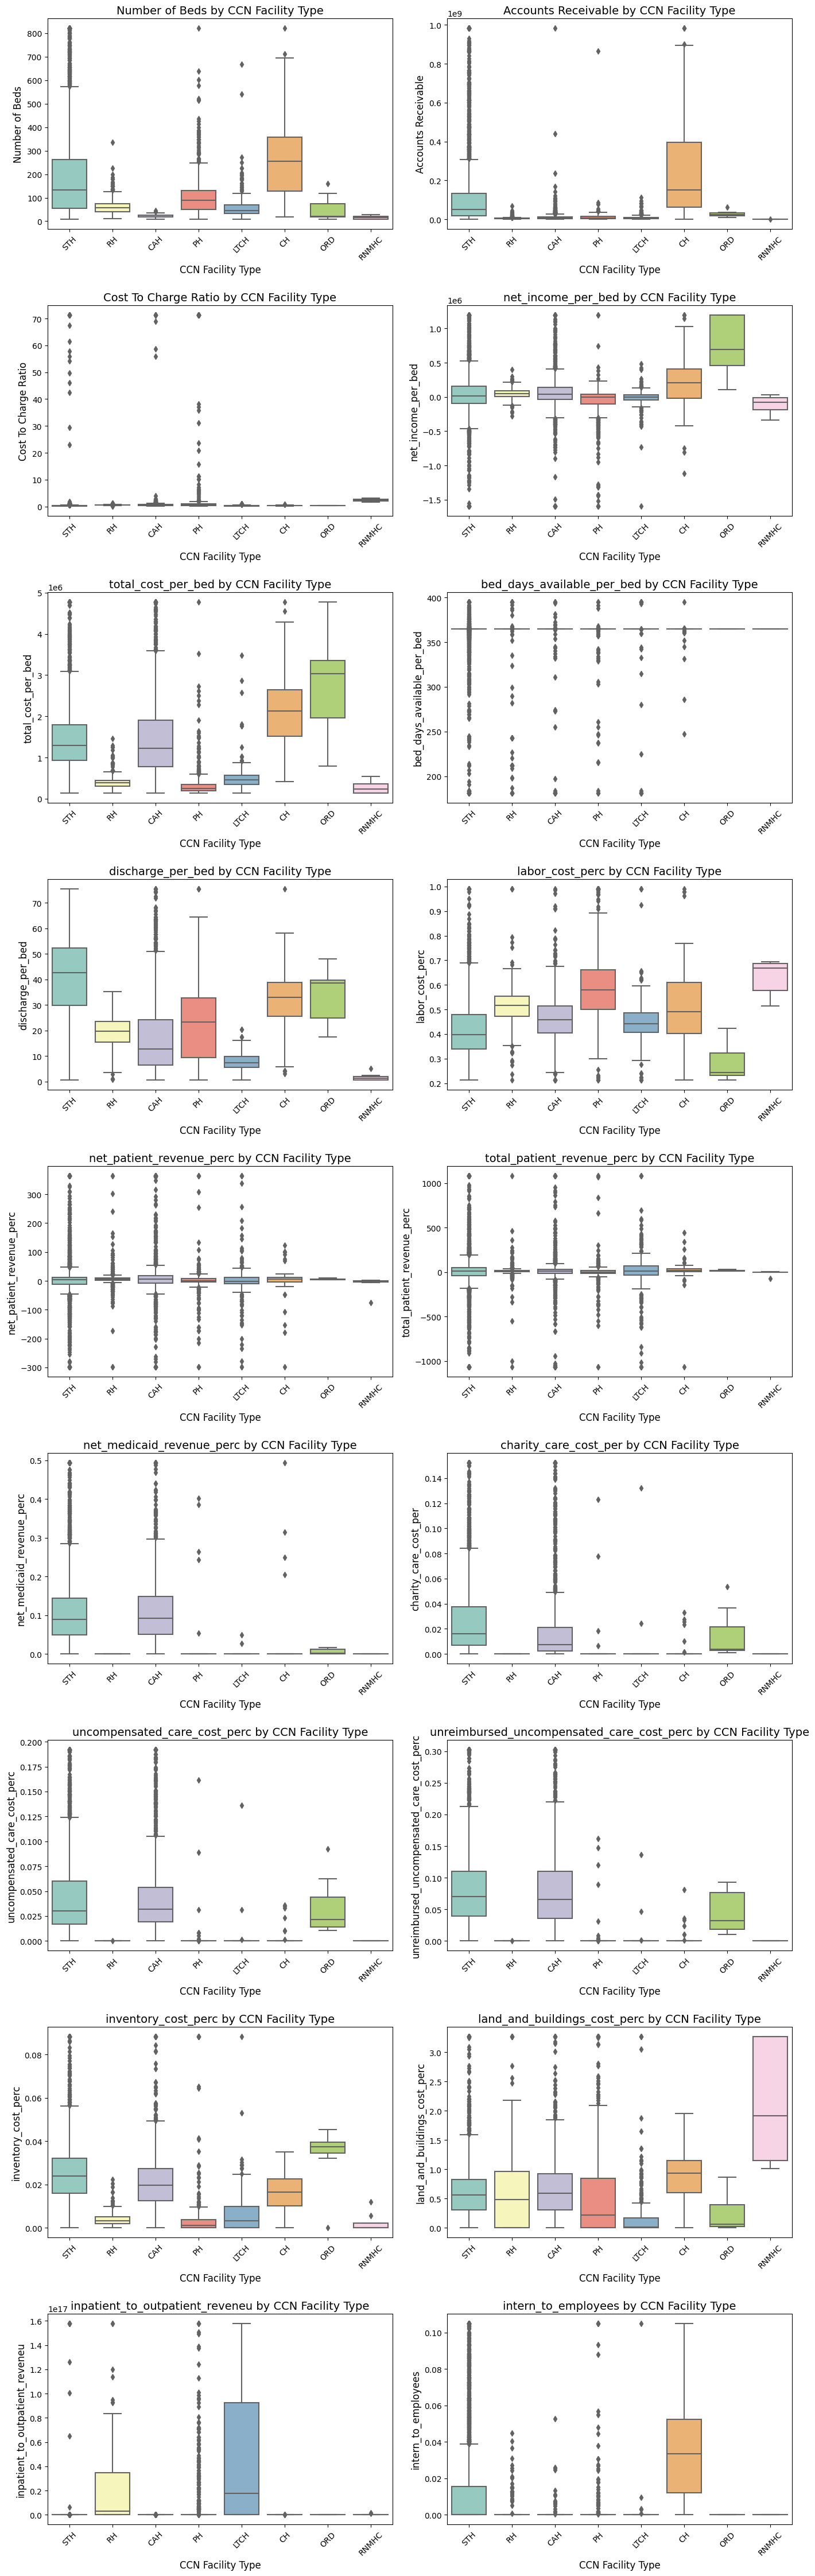


Summary statistics for Number of Beds by CCN Facility Type:
                         mean  median         std  count
CCN Facility Type                                       
CAH                 21.575000    25.0    5.192423   1360
CH                 268.937500   256.0  180.895557     64
LTCH                61.352071    44.0   59.012877    338
ORD                 53.285714    21.0   60.115761      7
PH                 108.336222    88.0   96.280756    577
RH                  62.534819    57.0   35.512659    359
RNMHC               15.500000    16.5    7.250616      8
STH                193.969063   134.0  183.541490   3200
ANOVA results for Number of Beds by CCN Facility Type: F-statistic=245.1495, p-value=0.0000

Summary statistics for Accounts Receivable by CCN Facility Type:
                           mean       median           std  count
CCN Facility Type                                                
CAH                1.178832e+07    6214348.0  3.256568e+07   1360
CH           

/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

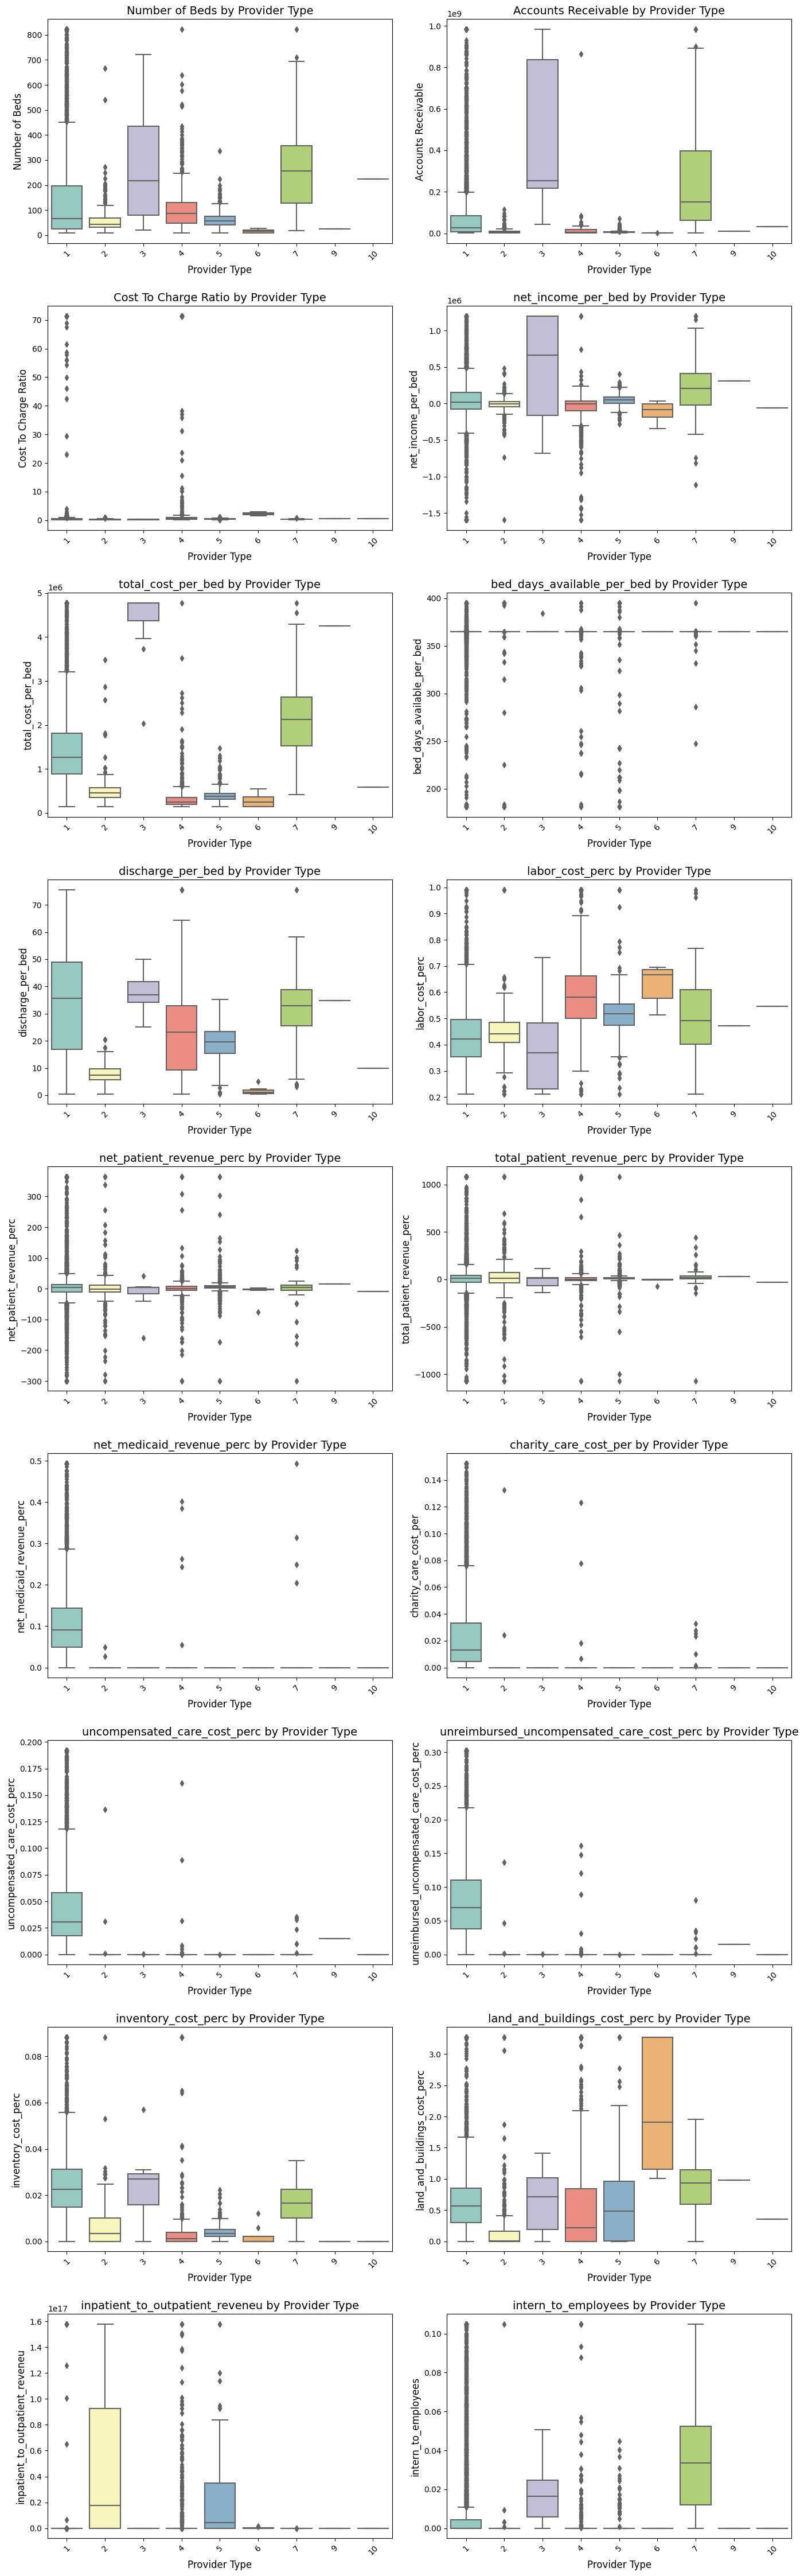


Summary statistics for Number of Beds by Provider Type:
                     mean  median         std  count
Provider Type                                       
1              142.147311    67.0  172.501619   4555
2               60.747024    43.5   58.466306    336
3              264.545455   217.0  235.296988     11
4              108.336222    88.0   96.280756    577
5               62.641667    57.0   35.521063    360
6               15.500000    16.5    7.250616      8
7              268.937500   256.0  180.895557     64
9               25.000000    25.0         NaN      1
10             225.000000   225.0         NaN      1
ANOVA results for Number of Beds by Provider Type: F-statistic=29.2187, p-value=0.0000

Summary statistics for Accounts Receivable by Provider Type:
                       mean       median           std  count
Provider Type                                                
1              8.844932e+07   25881482.0  1.664256e+08   4555
2              9.893234e+

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/4055924247.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df.groupby(cat_var)[metric].agg(['mean', 'median', 'std', 'count'])
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/4055924247.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df.groupby(cat_var)[metric].agg(['mean', 'median', 'std', 'count'])
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/4055924247.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

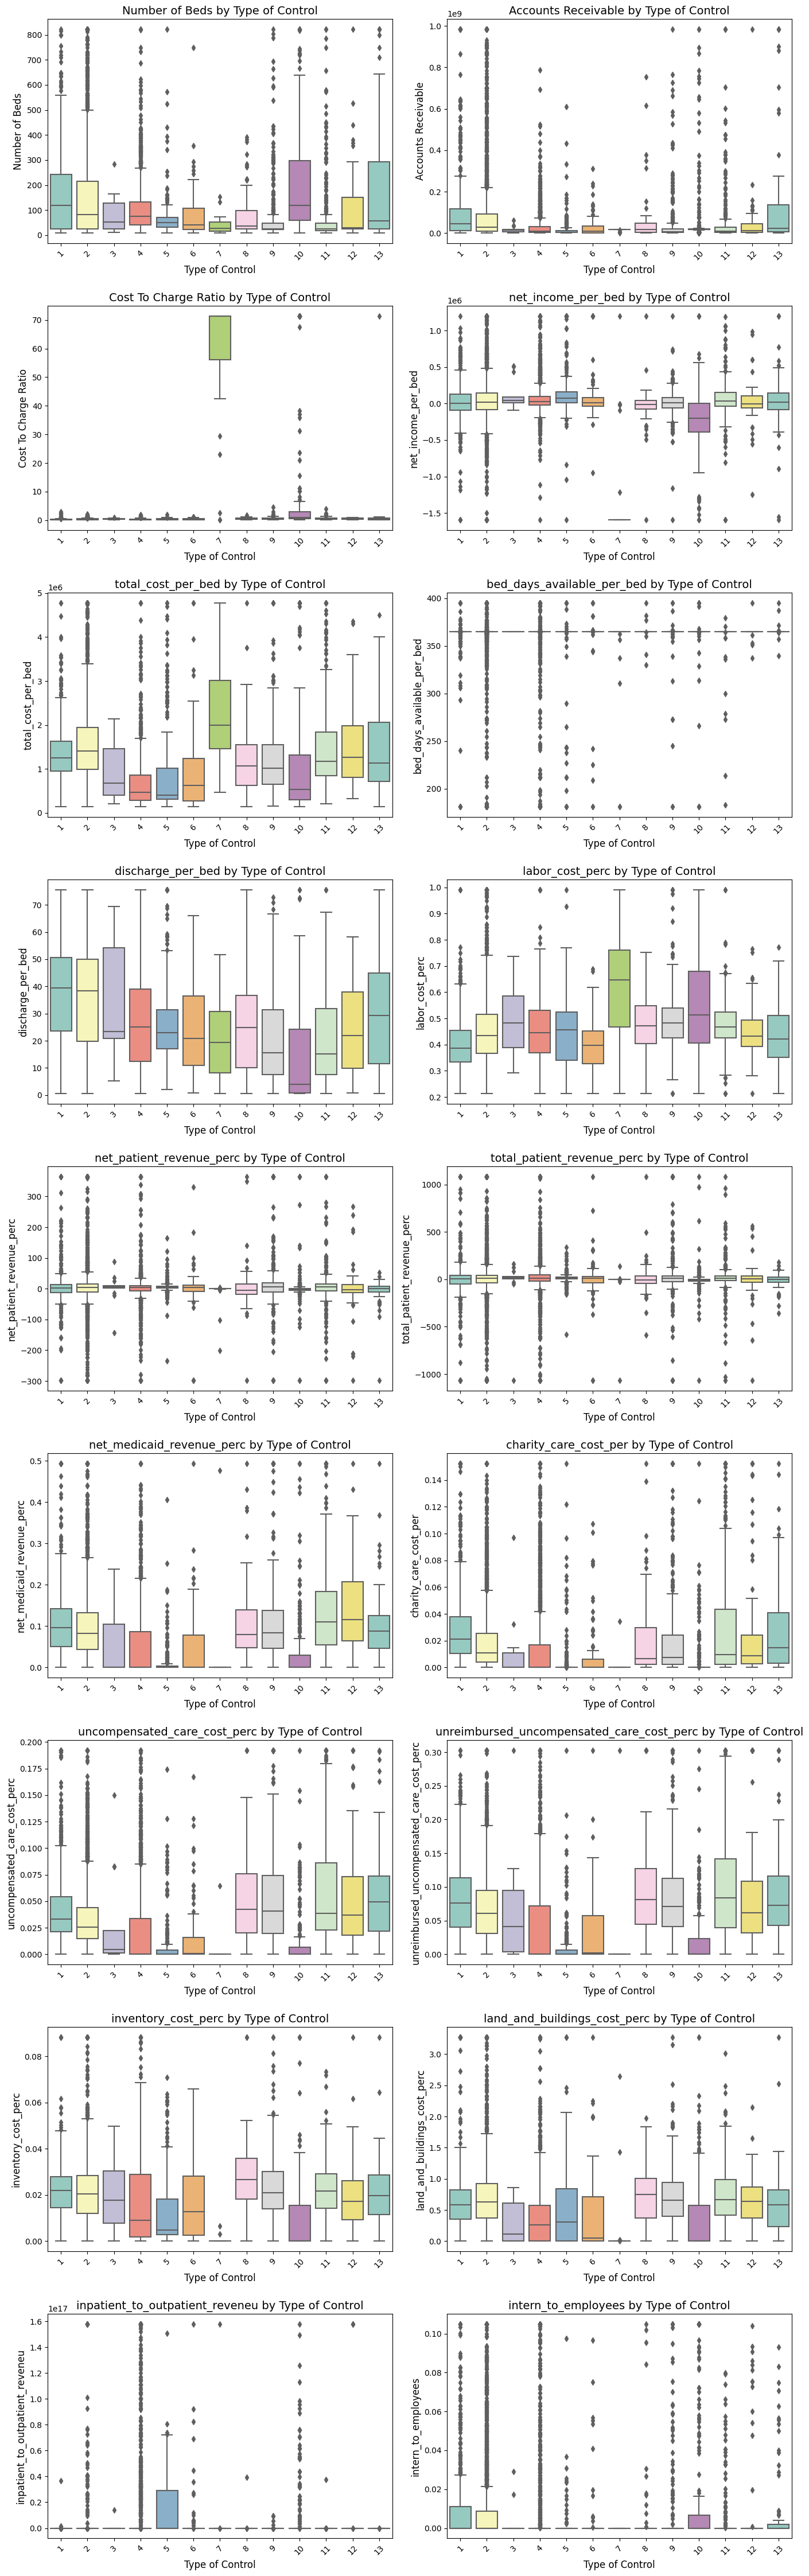


Summary statistics for Number of Beds by Type of Control:
                       mean  median         std  count
Type of Control                                       
1                166.622034   118.5  165.461882    590
2                155.564583    82.0  182.386971   2400
3                 83.230769    53.0   80.085531     13
4                107.519770    75.0  103.279077   1391
5                 67.560484    49.5   85.689844    248
6                 84.244681    40.5  102.777836     94
7                 37.390244    27.0   31.836204     41
8                 81.192308    35.5   96.792596     78
9                 72.747922    25.0  128.243237    361
10               207.725581   119.0  208.726387    215
11                74.430678    25.0  134.494068    339
12               111.703125    30.0  150.776896     64
13               193.683544    57.0  252.424629     79
ANOVA results for Number of Beds by Type of Control: F-statistic=29.9506, p-value=0.0000

Summary statistics for Acc

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/4055924247.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df.groupby(cat_var)[metric].agg(['mean', 'median', 'std', 'count'])
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/4055924247.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df.groupby(cat_var)[metric].agg(['mean', 'median', 'std', 'count'])
/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/4055924247.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

In [37]:
for cat_var in categorical_cols:
    # Set up a grid for boxplots for the current categorical variable
    num_metrics = len(numerical_cols)
    num_cols = 2
    num_rows = -(-num_metrics // num_cols)  # Ceiling division
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 5 * num_rows))
    
    for i, metric in enumerate(numerical_cols):
        row, col = divmod(i, num_cols)
        sns.boxplot(x=cat_var, y=metric, data=df, ax=axes[row, col], palette="Set3")
        axes[row, col].set_title(f"{metric} by {cat_var}", fontsize=14)
        axes[row, col].set_xlabel(cat_var, fontsize=12)
        axes[row, col].set_ylabel(metric, fontsize=12)
        axes[row, col].tick_params(axis='x', rotation=45)
    
    # Remove empty subplots if the number of metrics is odd
    if num_metrics % num_cols != 0:
        for j in range(num_metrics, num_rows * num_cols):
            fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout()
    plt.show()
    
    # Perform statistical tests for each metric
    for metric in numerical_cols:
        unique_categories = df[cat_var].nunique()

        print(f"\nSummary statistics for {metric} by {cat_var}:")
        summary_stats = df.groupby(cat_var)[metric].agg(['mean', 'median', 'std', 'count'])
        print(summary_stats)
        
        if unique_categories > 2:
            # Run ANOVA
            groups = [df[df[cat_var] == category][metric] for category in df[cat_var].unique()]
            stat, p_value = f_oneway(*groups)
            print(f"ANOVA results for {metric} by {cat_var}: F-statistic={stat:.4f}, p-value={p_value:.4f}")
        elif unique_categories == 2:
            # Run t-test
            category_values = df[cat_var].unique()
            group1 = df[df[cat_var] == category_values[0]][metric]
            group2 = df[df[cat_var] == category_values[1]][metric]
            stat, p_value = ttest_ind(group1, group2, equal_var=False)
            print(f"T-test results for {metric} by {cat_var}: t-statistic={stat:.4f}, p-value={p_value:.4f}")       


The analysis highlights substantial differences in operational and financial metrics across hospital categories:

- Urban vs. Rural Hospitals: Urban hospitals report higher numbers of beds, greater discharges per bed, and higher accounts receivable and net_income_per_bed. Rural hospitals, on the other hand, incur higher total_cost_per_bed, rely more on net_medicaid_revenue_perc, and face greater charity_care_cost_per and uncompensated_care_cost_perc.

- CCN Facility Types: Short Term Hospitals (STH) and Children’s Hospitals (CH) dominate in accounts receivable and discharge_per_bed, while Critical Access Hospitals (CAH) and Rural Nursing and Maternity Hospitals (RNMHC) report fewer beds and higher cost_to_charge_ratio. STH and CAH also lead in uncompensated_care_cost_perc and net_medicaid_revenue_perc.

- Provider Types: Analysis of provider types shows marked variability in metrics. Provider Type 7 has the highest mean and median number of beds, whereas Provider Type 6 has the lowest. Provider Type 3 leads in accounts receivable and net_income_per_bed, while Provider Type 6 reports the lowest for both. Provider Type 3 also has the highest total_cost_per_bed, and Provider Type 1 demonstrates higher charity_care_cost_per and uncompensated_care_cost_perc compared to others. ANOVA results confirm significant differences (p < 0.001) across all metrics.

- Types of Control: Type of Control analysis shows significant disparities. Type 10 leads in the number of beds, while Type 7 reports the fewest. Type 13 has the highest accounts receivable, and Type 7 reports the highest cost_to_charge_ratio. Type 5 leads in net_income_per_bed, while Type 7 reports the greatest losses. Variations are also noted in charity_care_cost_per and uncompensated_care_cost_perc, with Type 11 showing the highest values in both.

Overall, the findings indicate statistically significant variations in financial, operational, and care-related metrics, underlining the diverse challenges and roles hospitals play based on their classification.

## Data Preprocessing

In [38]:
numerical_cols, categorical_cols

(Index(['Number of Beds', 'Accounts Receivable', 'Cost To Charge Ratio',
        'net_income_per_bed', 'total_cost_per_bed',
        'bed_days_available_per_bed', 'discharge_per_bed', 'labor_cost_perc',
        'net_patient_revenue_perc', 'total_patient_revenue_perc',
        'net_medicaid_revenue_perc', 'charity_care_cost_per',
        'uncompensated_care_cost_perc',
        'unreimbursed_uncompensated_care_cost_perc', 'inventory_cost_perc',
        'land_and_buildings_cost_perc', 'inpatient_to_outpatient_reveneu',
        'intern_to_employees'],
       dtype='object'),
 Index(['Rural Versus Urban', 'CCN Facility Type', 'Provider Type',
        'Type of Control'],
       dtype='object'))

In [39]:
numerical_data = df[numerical_cols]
categorical_data = df[categorical_cols]

In [40]:
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(numerical_data)
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_cols)

In [41]:
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(categorical_data)
encoded_categorical_df = pd.DataFrame(
    encoded_categorical_data, 
    columns=encoder.get_feature_names_out(categorical_cols)
)

In [42]:
processed_df = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)
processed_df.head()

Number of Beds  Accounts Receivable  Cost To Charge Ratio  \
0       -0.368216            -0.293642             -0.158508   
1       -0.543543             1.206884             -0.108895   
2       -0.568590            -0.469001             -0.045253   
3        0.088885            -0.150039             -0.147167   
4       -0.662515            -0.385635             -0.127502   

   net_income_per_bed  total_cost_per_bed  bed_days_available_per_bed  \
0            0.035472           -1.227866                    -6.88095   
1           -0.342398           -0.089198                    -6.88095   
2           -0.242898           -1.227866                    -6.88095   
3           -0.345873           -1.156116                    -6.88095   
4           -0.025774           -1.033439                    -6.88095   

   discharge_per_bed  labor_cost_perc  net_patient_revenue_perc  \
0          -1.386224        -0.051432                 -0.023624   
1          -0.598605        -0.204037                 -0.318404   
2          -1.531443         1.183378                 -0.062568   
3          -1.024890        -0.718086                 -0.088709   
4          -1.543194        -1.209355                  0.171038   

   total_patient_revenue_perc  ...  Type of Control_4  Type of Control_5  \
0                    0.081861  ...                1.0                0.0   
1                   -0.249479  ...                0.0                0.0   
2                   -0.037490  ...                1.0                0.0   
3                   -0.105495  ...                0.0                0.0   
4                    0.233749  ...                0.0                0.0   

   Type of Control_6  Type of Control_7  Type of Control_8  Type of Control_9  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                1.0   

   Type of Control_10  Type of Control_11  Type of Control_12  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   Type of Control_13  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  

[5 rows x 50 columns]

## Modeling

### Clustering

In [43]:
inertia = []
silhouette_scores = []
cluster_range = range(2, 30)  # Testing cluster counts from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_df)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(processed_df, kmeans.labels_)
    silhouette_scores.append(score)

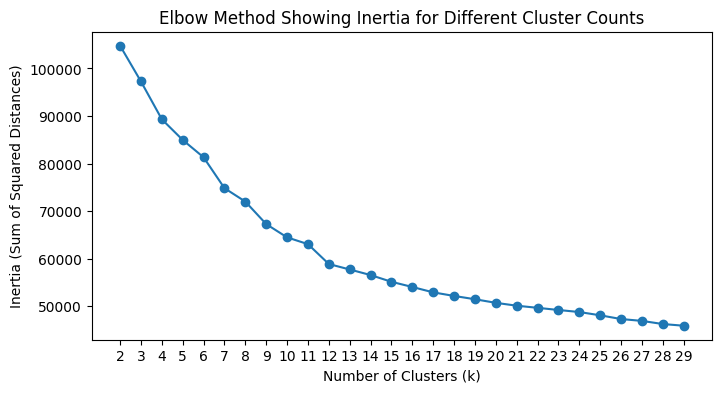

In [44]:
# Plot Elbow Method for Inertia
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method Showing Inertia for Different Cluster Counts")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.xticks(cluster_range)
plt.show()

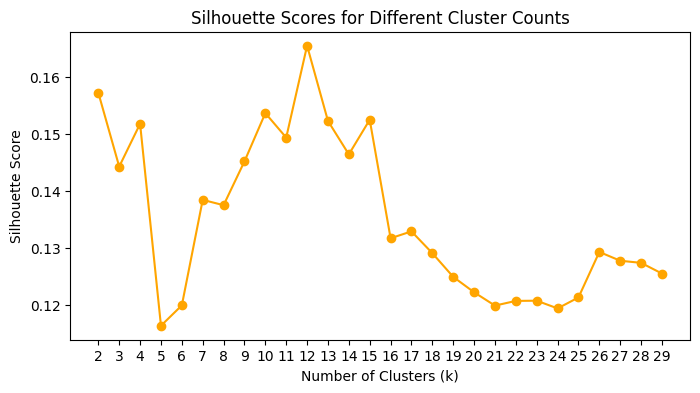

In [45]:
# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Scores for Different Cluster Counts")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(cluster_range)
plt.show()

In [46]:
optimal_clusters = 12

### Cluster Analysis

In [47]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(processed_df)

df['Cluster'] = kmeans.labels_

/var/folders/xk/5gx1tq55563djqn2f91dfp040000gn/T/ipykernel_88969/2231601485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = kmeans.labels_


In [48]:
cluster_sizes = df['Cluster'].value_counts().reset_index()
cluster_sizes.columns = ['Cluster', 'Count']
print("\nCluster Sizes:")
cluster_sizes


Cluster Sizes:


Cluster  Count
0        10   1368
1         5   1356
2         7   1065
3         1    522
4         4    422
5         3    311
6         9    238
7         2    145
8         8    141
9        11    137
10        0    133
11        6     75

In [49]:
# Compute summary statistics for each cluster
cluster_summary = df.groupby('Cluster')[numerical_cols].mean().sort_values('net_income_per_bed', ascending=False)
print("Cluster Summary Statistics:")
cluster_summary

Cluster Summary Statistics:


Number of Beds  Accounts Receivable  Cost To Charge Ratio  \
Cluster                                                              
4             56.755924         5.107562e+07              0.335378   
9            565.663866         6.948221e+08              0.244909   
1            120.532567         6.116319e+07              0.320476   
3            313.987138         1.387981e+08              0.273470   
11           113.985401         6.614555e+07              0.371732   
5             33.741150         1.210585e+07              0.558278   
0            145.360902         6.480718e+07              0.306908   
10           187.729532         8.876567e+07              0.255323   
7             81.961502         9.070383e+06              0.703682   
2             74.158621         1.409610e+07              0.254268   
8             82.468085         3.989087e+07              0.670407   
6             94.880000         1.664321e+07             67.045566   

         net_income_per_bed  total_cost_per_bed  bed_days_available_per_bed  \
Cluster                                                                       
4             520519.878093        2.888264e+06                  365.061453   
9              97815.183802        2.062529e+06                  363.093919   
1              55011.440291        1.135416e+06                  363.058556   
3              27888.572185        1.516081e+06                  362.965315   
11              3449.346267        1.295374e+06                  364.500468   
5              -3519.867730        1.149418e+06                  365.136907   
0              -7504.220802        1.247822e+06                  365.056857   
10            -10258.387562        1.414168e+06                  364.124454   
7             -13916.228959        4.125292e+05                  364.749555   
2             -18242.173385        5.922584e+05                  364.994067   
8             -50634.709785        4.756807e+05                  205.273226   
6            -987475.157778        1.533894e+06                  361.394500   

         discharge_per_bed  labor_cost_perc  net_patient_revenue_perc  \
Cluster                                                                 
4                42.852409         0.397420                 10.180882   
9                47.734868         0.444478                  2.278002   
1                34.214694         0.407820                  1.498152   
3                45.713968         0.420842                  0.269361   
11               33.096239         0.475544                264.240408   
5                15.580410         0.470934                  3.283653   
0                35.393409         0.461350               -219.872328   
10               45.849962         0.404784                  1.439423   
7                18.916811         0.544252                  2.572661   
2                12.403055         0.464098                  2.686186   
8                13.610433         0.449907                  1.473968   
6                12.948003         0.654283                 -1.624029   

         total_patient_revenue_perc  net_medicaid_revenue_perc  \
Cluster                                                          
4                         21.720947                   0.083875   
9                          3.512223                   0.110231   
1                         12.651329                   0.109487   
3                         18.218891                   0.151460   
11                       761.471412                   0.106747   
5                          4.082279                   0.123564   
0                       -782.112849                   0.097818   
10                         5.263327                   0.097367   
7                          3.569631                   0.000756   
2                         20.953729                   0.010673   
8                         -0.700521                   0.066702   
6                         -5.975805     

In [50]:
for col in categorical_cols:
    category_distribution = df.groupby('Cluster')[col].value_counts(normalize=True).unstack()
    print(f"\nCategory Distribution for '{col}' by Cluster:")
    print(category_distribution)


Category Distribution for 'Rural Versus Urban' by Cluster:
Rural Versus Urban         R         U
Cluster                               
0                   0.406015  0.593985
1                   0.490421  0.509579
2                   0.020690  0.979310
3                   0.340836  0.659164
4                   0.514218  0.485782
5                   0.882743  0.117257
6                   0.546667  0.453333
7                   0.071362  0.928638
8                   0.297872  0.702128
9                   0.390756  0.609244
10                  0.306287  0.693713
11                  0.569343  0.430657

Category Distribution for 'CCN Facility Type' by Cluster:
CCN Facility Type       CAH        CH      LTCH       ORD        PH        RH  \
Cluster                                                                         
0                  0.180451  0.007519  0.052632       NaN  0.045113  0.015038   
1                  0.250958       NaN  0.001916  0.001916  0.003831       NaN   
2          

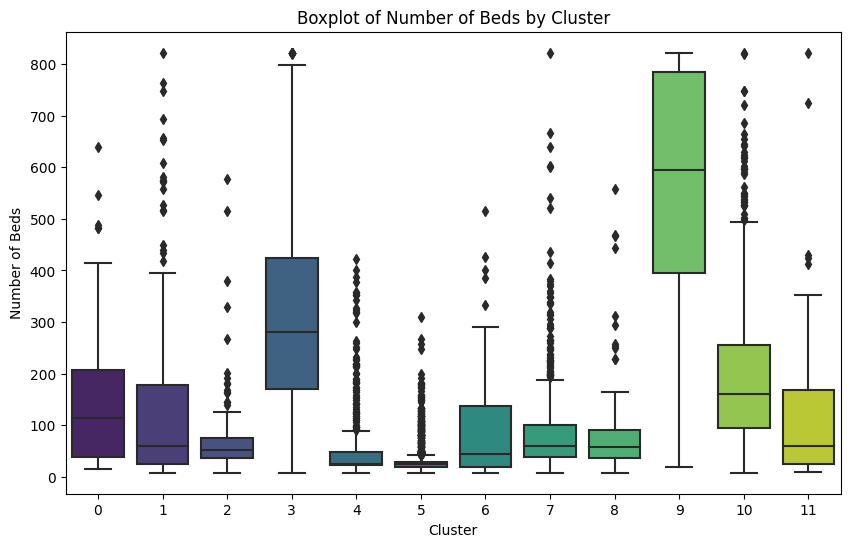

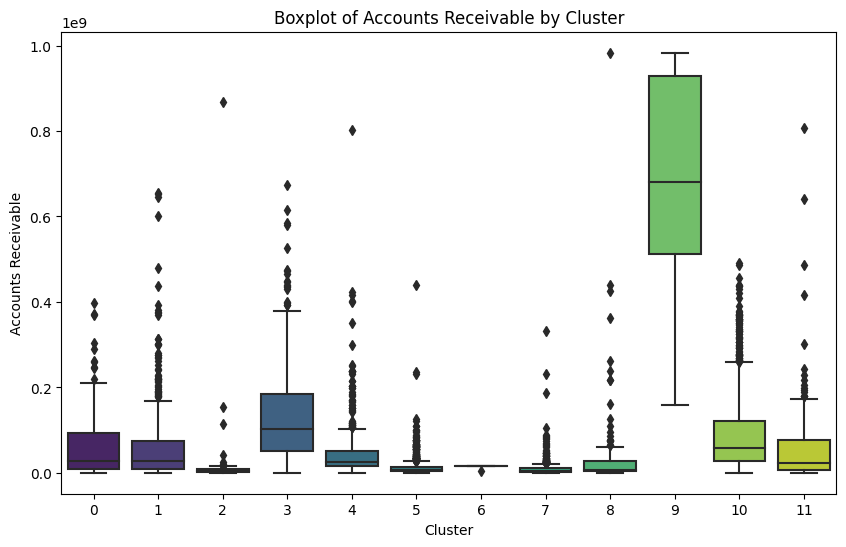

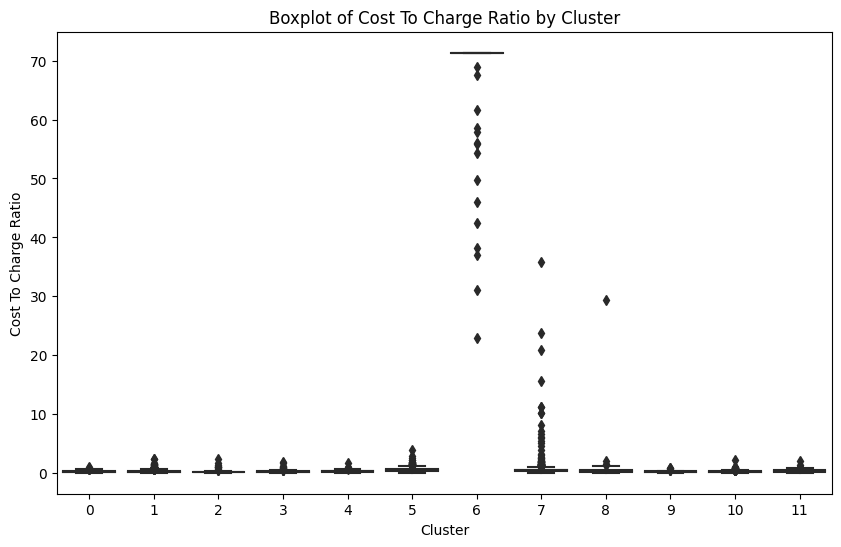

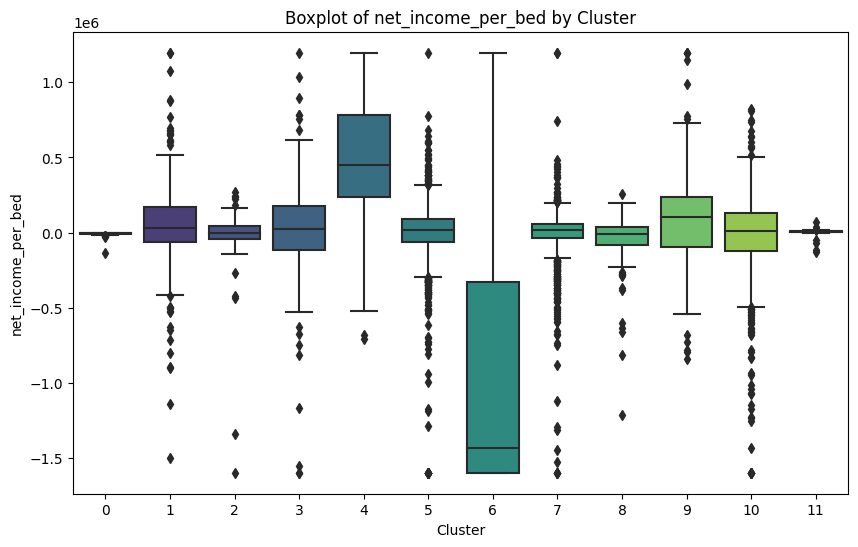

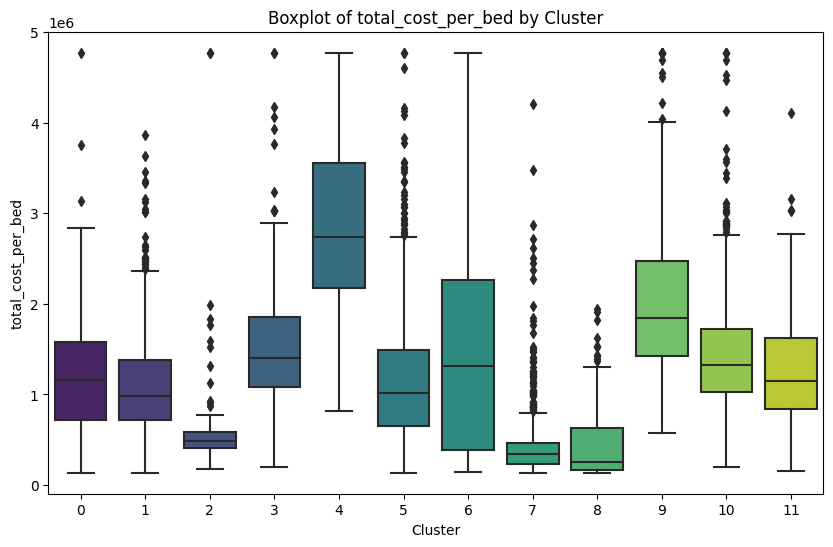

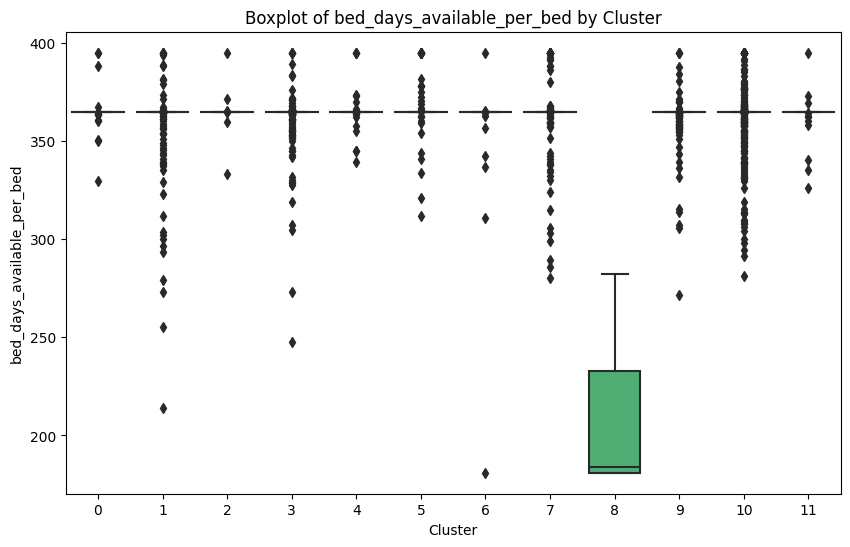

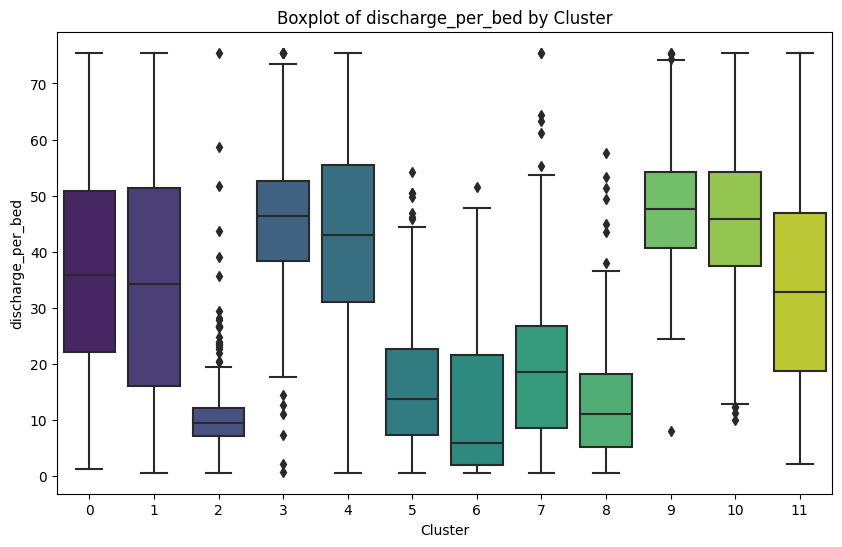

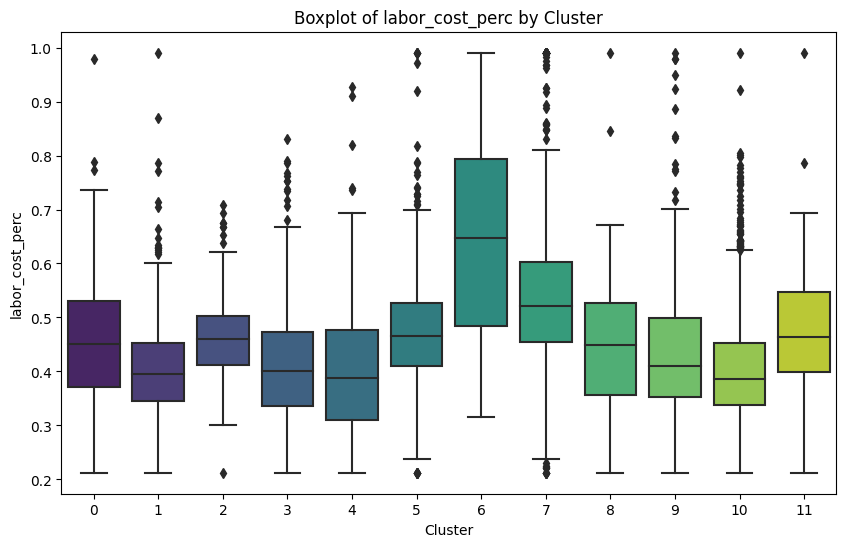

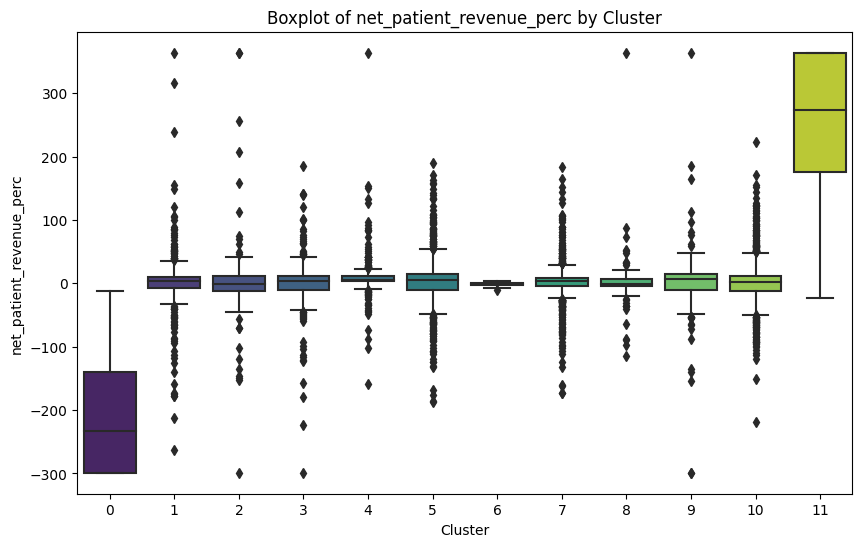

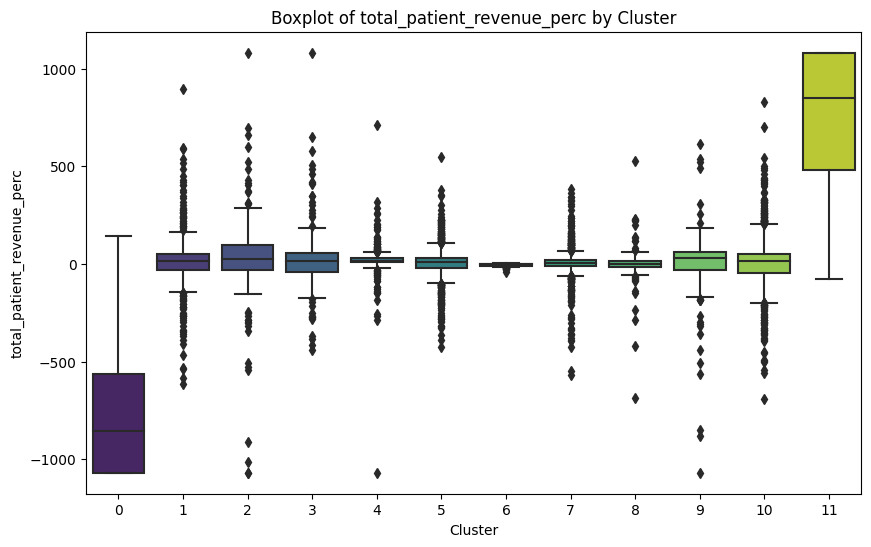

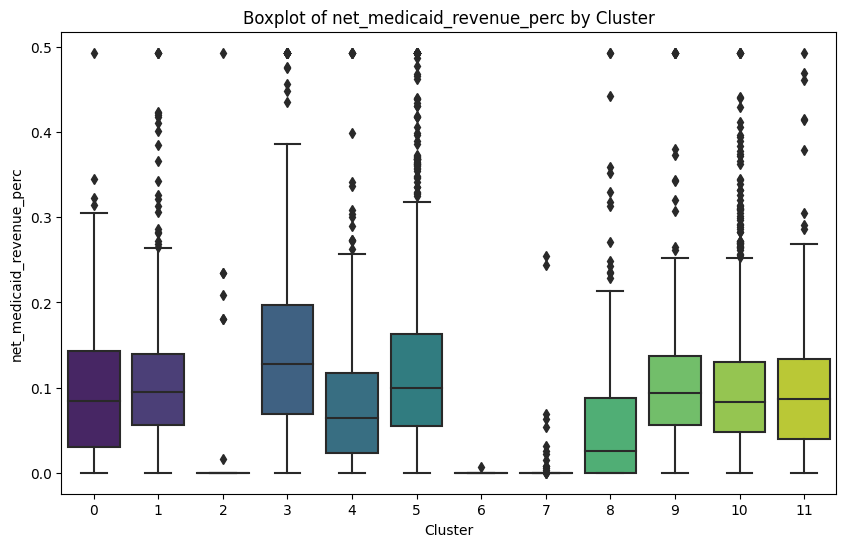

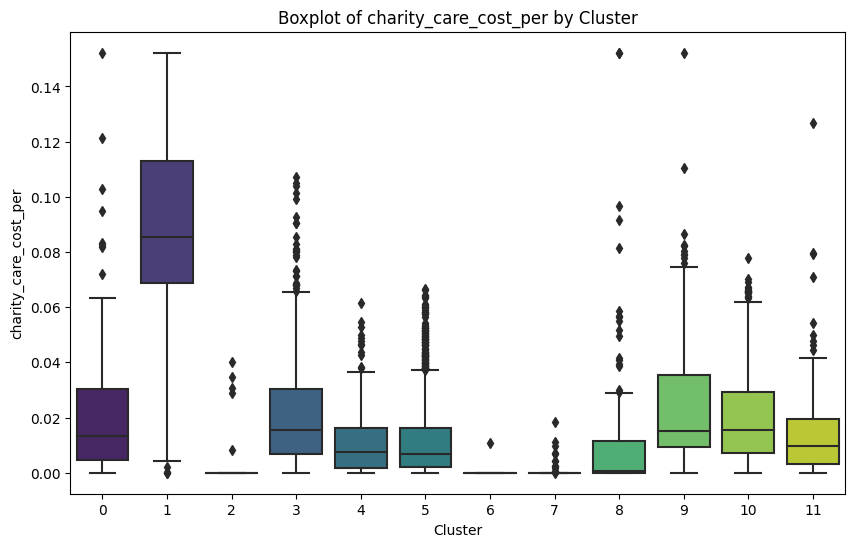

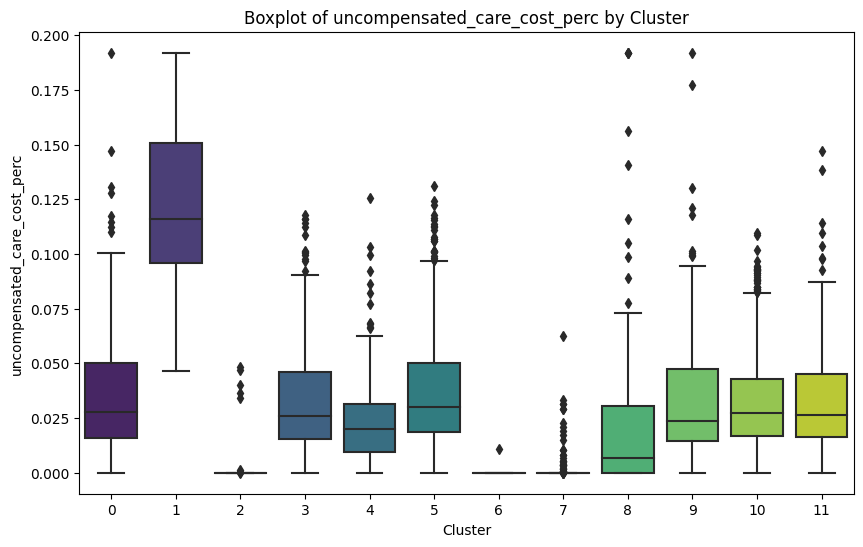

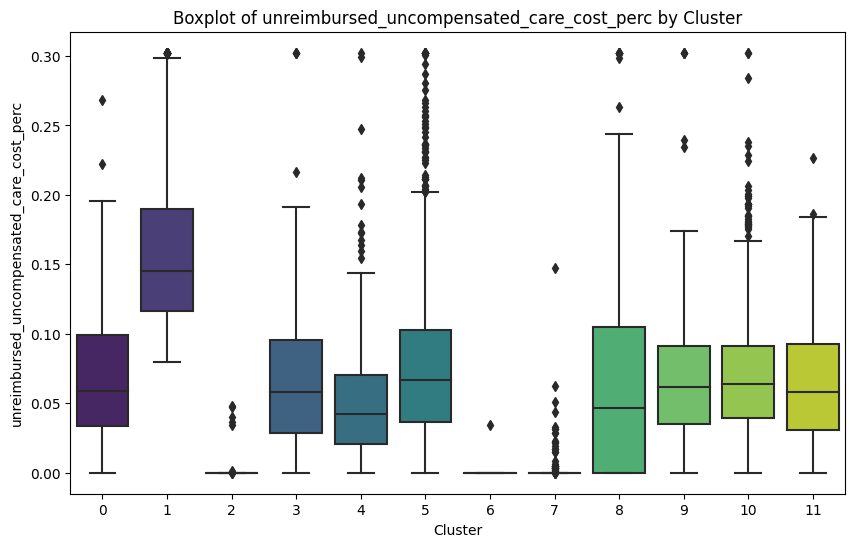

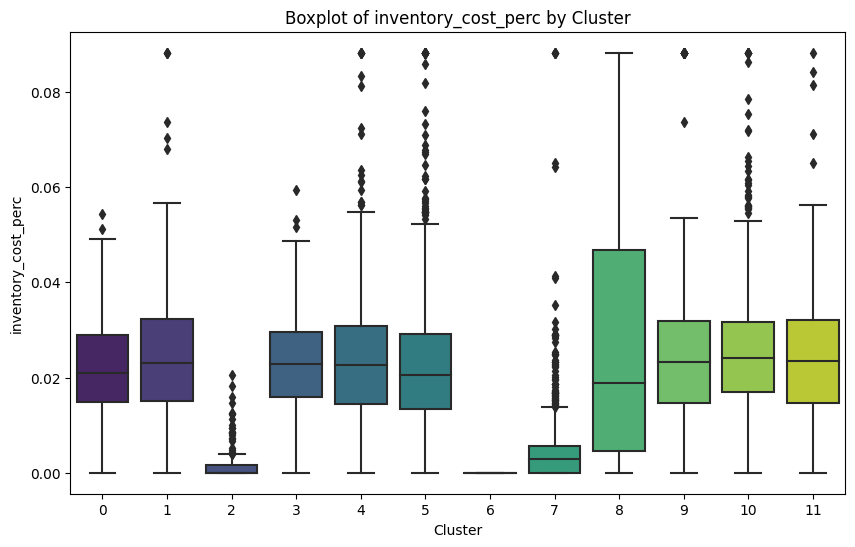

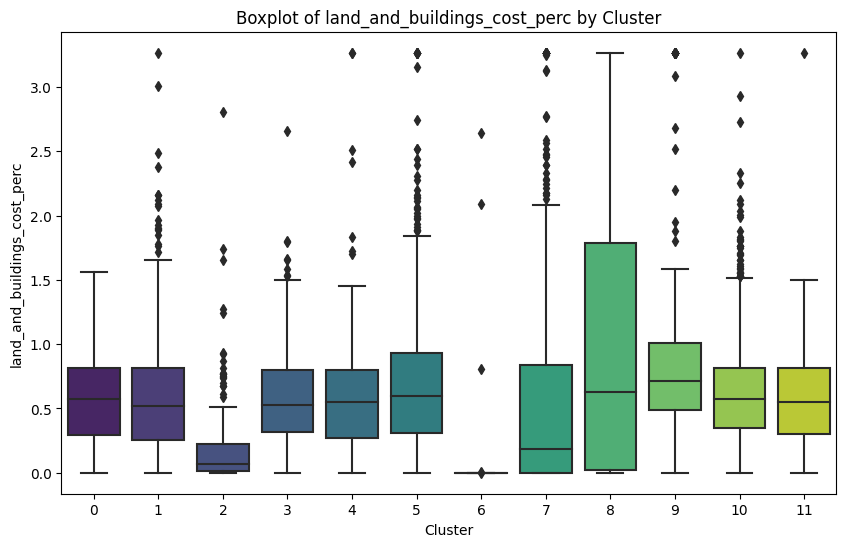

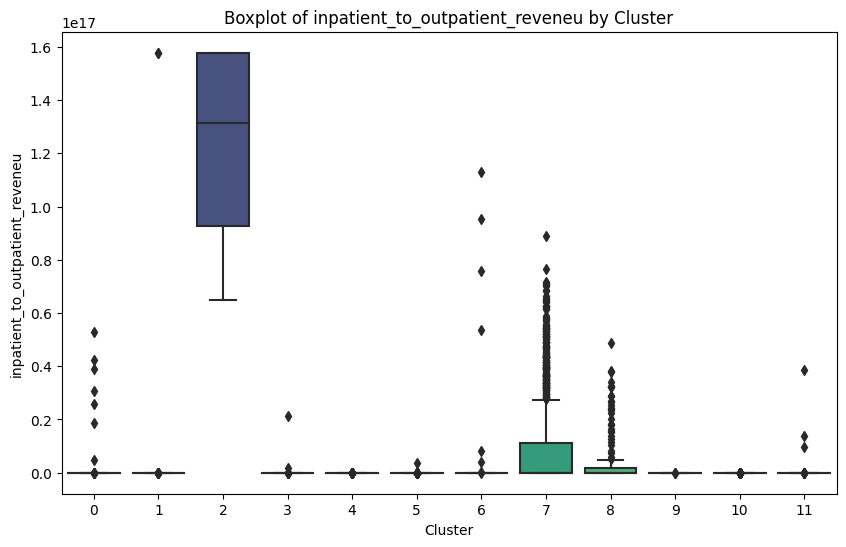

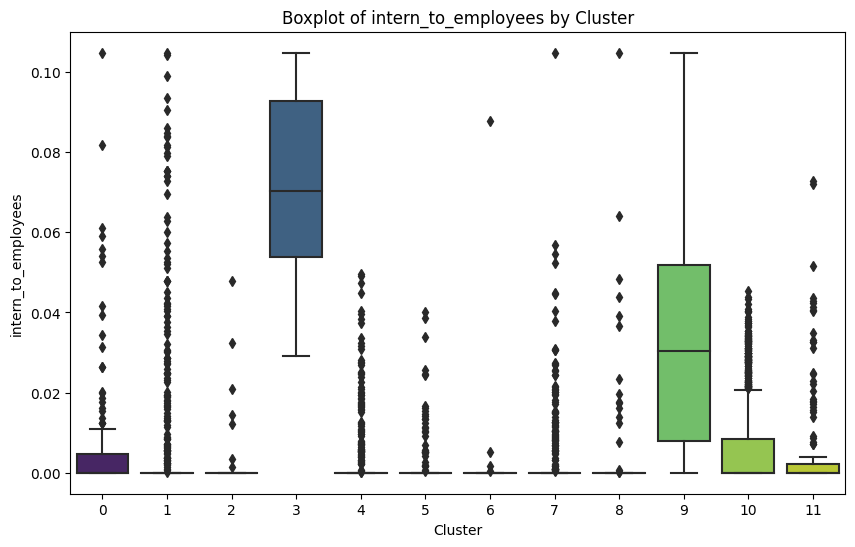

In [51]:
for feature in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Cluster', y=feature, palette='viridis')
    plt.title(f"Boxplot of {feature} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.show()


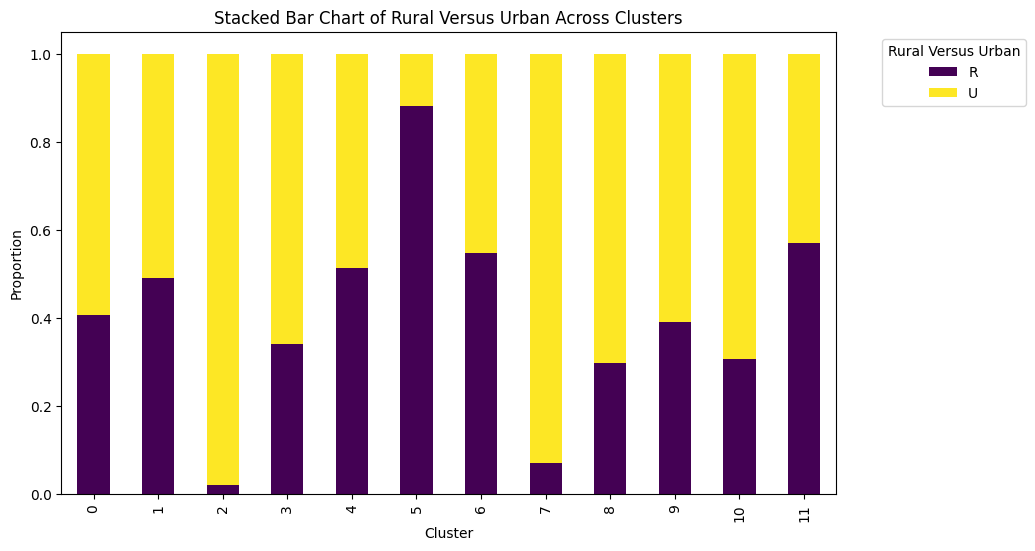

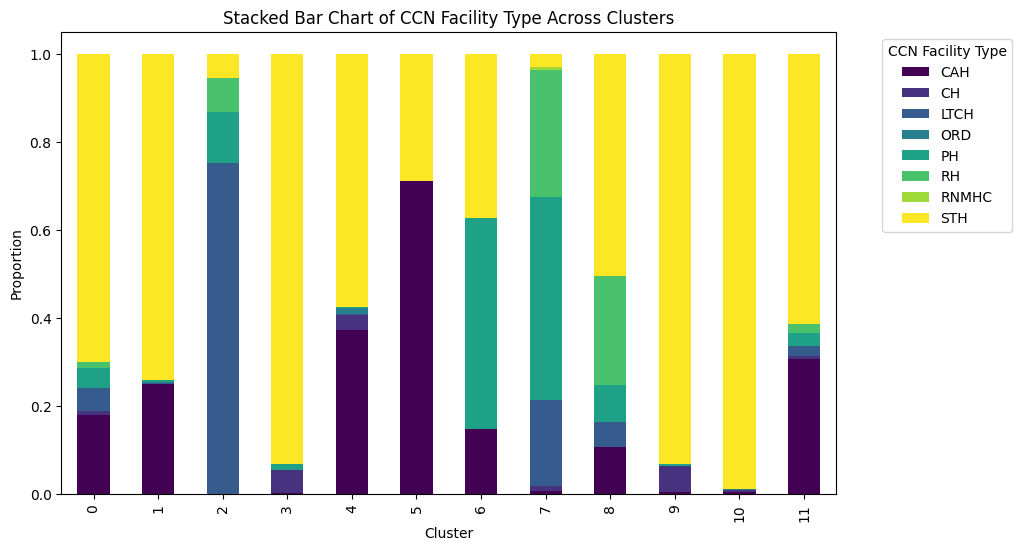

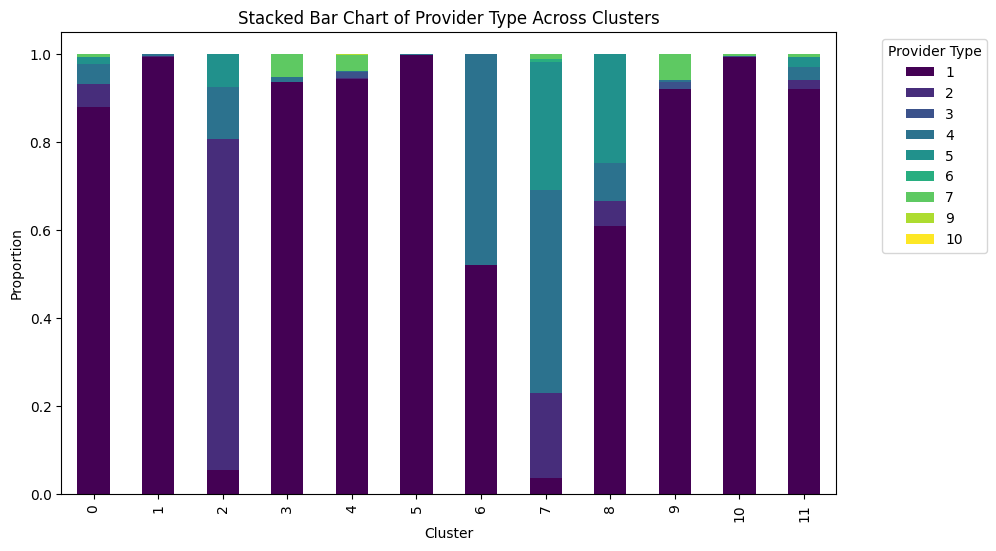

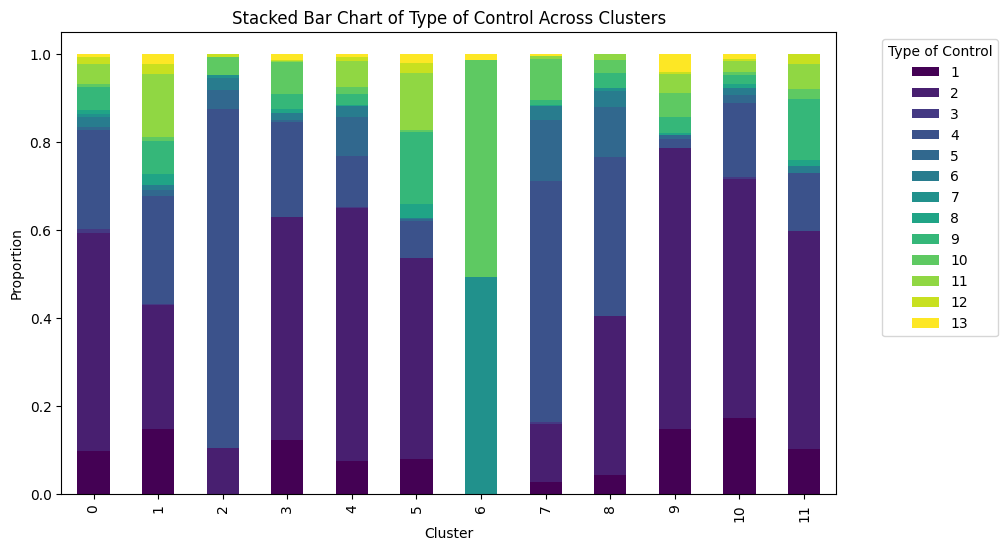

In [52]:
for col in categorical_cols:
    category_counts = df.groupby('Cluster')[col].value_counts(normalize=True).unstack()

    category_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title(f"Stacked Bar Chart of {col} Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


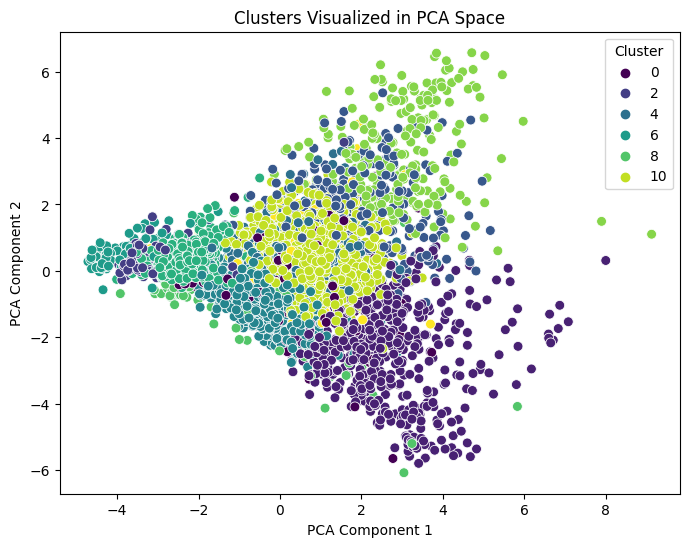

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_numerical_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['Cluster'], palette='viridis', s=50)
plt.title("Clusters Visualized in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Apply t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_components = tsne.fit_transform(scaled_numerical_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_components[:, 0], y=tsne_components[:, 1], hue=df['Cluster'], palette='viridis', s=50)
plt.title("Clusters Visualized in t-SNE Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()


**Insights**

Cluster Characteristics:
- High-performing clusters exhibited greater financial stability, characterized by higher net_income_per_bed and lower cost_to_charge_ratio.
- Clusters comprising rural hospitals showed lower profitability and higher dependency on Medicaid revenue, reflecting their unique financial challenges.
- Specialized hospital types, such as Children’s Hospitals and Long-Term Care Hospitals, formed distinct clusters with operational and financial profiles that align with their specialized roles.

Categorical Variable Impact:
- Non-numerical variables like Rural Versus Urban, CCN Facility Type, and Provider Type significantly influenced cluster formation, underscoring the importance of considering these attributes in hospital segmentation.
- Urban hospitals generally clustered separately from rural hospitals, highlighting differences in scale, resources, and financial performance.

## Project Summary


This project analyzed hospital financial and operational metrics to address challenges in balancing service quality with cost constraints. Key findings and outcomes include:

Analysis of Key Metrics:
- Examined metrics such as cost_to_charge_ratio, net_income_per_bed, and labor_cost_perc to identify drivers of high costs and inefficiencies.
- Highlighted significant disparities in financial and operational performance between urban and rural hospitals.

Clustering and Segmentation:
- Segmented hospitals into distinct clusters based on financial health, efficiency, and operational characteristics using clustering techniques.
- Identified high-performing clusters to serve as benchmarks for best practices.
- Pinpointed financially vulnerable clusters requiring targeted support and interventions.

Key Insights:
- Urban hospitals generally outperform rural facilities in profitability and operational efficiency.
- Variability in hospital performance highlights the need for tailored recommendations and strategies.

Actionable Outcomes:
- Provided data-driven recommendations to improve cost efficiency and enhance revenue streams.
- Offered insights to support financially strained hospitals through better resource allocation and policy adjustments.

Future Opportunities:
- Integrating external socio-economic data for deeper analysis.
- Building predictive models for financial forecasting.
- Engaging stakeholders to validate and refine recommendations for impactful implementation.